# 1. Function part

## 1.1 environment

In [1]:
import math
import lmdb
import random
import pickle
import shutil
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import io
import scipy.spatial.distance as sp_distance

from ase.io import read
from ase.atoms import Atoms
from spektral.data import Dataset, Graph
from ocpmodels.datasets import LmdbDataset
from ase.constraints import FixAtoms, FixCartesian
from ase.build import add_adsorbate, molecule, fcc111

from sklearn.model_selection import train_test_split

from ocpre import *  # loading functions related with the program. 本项目相关的基础函数写在ocpre中

2024-01-21 15:31:45.210342: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-21 15:31:45.236902: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-21 15:31:45.351895: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-21 15:31:45.351918: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-21 15:31:45.352578: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

## 1.3 folder path

In [73]:
folder_path_all = "/media/zwbai/DATA/dft/all_copy/"  # Data storage folder, including output and input folders
output_path = folder_path_all + "output/"
input_path = folder_path_all + "input/"
data_path = "./vasp_cal/"
exist_folder(folder_path_all, is_creat=False)  # Need to create in advance
exist_folder(input_path, is_creat=False)  # Need to create in advance
exist_folder(output_path, is_creat=True)

# input
# They are mostly calculation result, so their names are ended with '_copy' or '_cal'
# 计算结果多以copy或者cal结尾
CONT_path = input_path + "Ex42-Cu-Bulk/"
Cu_bulk_copy = input_path + "Cu_bulk_copy/"
Cu_slab_copy = input_path + "Cu_slab_copy"
refer_bulk_copy = input_path + "refer_bulk_cal"  # i
refer_slab_copy = input_path + "refer_slab_cal"  # i
Cu_slab4_copy = input_path + "Cu_slab4_copy"
one_atom_copy = input_path + "one_atom_copy"
nostrain_molecule_copy = input_path + "nostrain_molecule_copy"
strain_adslab_copy = input_path + "strain_adslab_copy"  # i
dos_cal = input_path + "dos_cal"  # i

# output
Cu_bulk_path = output_path + "Cu_bulk"  #
Cu_slab_path = output_path + "Cu_slab"

refer_bulk_folder = output_path + "refer_bulk"
refer_slab_folder = output_path + "refer_slab"
Cu_slab4_folder = output_path + "Cu_slab4"
one_atom_folder = output_path + "one_atom"
nostrain_molecule_folder = output_path + "nostrain_molecule"
strain_adslab_folder = output_path + "strain_adslab"

# data
strain_value_dict = output_path + "strain_matrix_dict.pkl"
strain_value_list = output_path + "strain_matrix.npy"

ml_GNN_data_dict = output_path + "ml_GNN_data_dict.pkl"
pre_GNN_data_dict = output_path + "pre_GNN_data_dict.pkl"

lmdb_file_all = output_path + "CuO2_strain_all.lmdb"
lmdb_file_train = output_path + "CuO2_strain_train.lmdb"
lmdb_file_test = output_path + "CuO2_strain_test.lmdb"
lmdb_file_ml = output_path + "CuO2_strain_ml.lmdb"
lmdb_file_pre = output_path + "CuO2_strain_pre.lmdb"

dos_data_file = output_path + "dos_data.pkl"
dos_energy_data_file = output_path + "dos_energy_data.pkl"

pack_data_files = [
    strain_value_dict,
    strain_value_list,
    ml_GNN_data_dict,
    pre_GNN_data_dict,
    lmdb_file_all,
    lmdb_file_train,
    lmdb_file_test,
    dos_data_file,
    dos_energy_data_file,
]  # data for ML

folder '/media/zwbai/DATA/dft/all_copy/' exists
folder '/media/zwbai/DATA/dft/all_copy/input/' exists
folder '/media/zwbai/DATA/dft/all_copy/output/' exists


# 2. Initial cofiguration of bulk

In [3]:
bulk = int_bulk(CONT_path)
out_poscar(bulk, path=Cu_bulk_path)
print(bulk.get_cell())
print(bulk.get_positions())

3.636600176352717
Cell([[2.571464645163201, 0.0, 0.0], [1.2857323225816004, 2.226953707644869, 0.0], [0.0, 0.0, 6.2987762722568466]])
[[1.2857 0.7423 0.    ]
 [0.     1.4846 2.0996]
 [0.     0.     4.1992]]


In [4]:
bulk = read_one_car(Cu_bulk_copy)
slab = vac_ext(bulk, vacuum_h=30.0, ads_layer=4)  # 多加4个原子并添加真空层
out_poscar(slab, path=Cu_slab_path)

In [5]:
# 无应变的slab，优化计算结果在'./vasp_cala/Cu_slab_copy/CONTCAR'
slab_op = read_one_car(Cu_slab_copy)

# 3. strain space 

## 3.1 strain value 

Input is dict


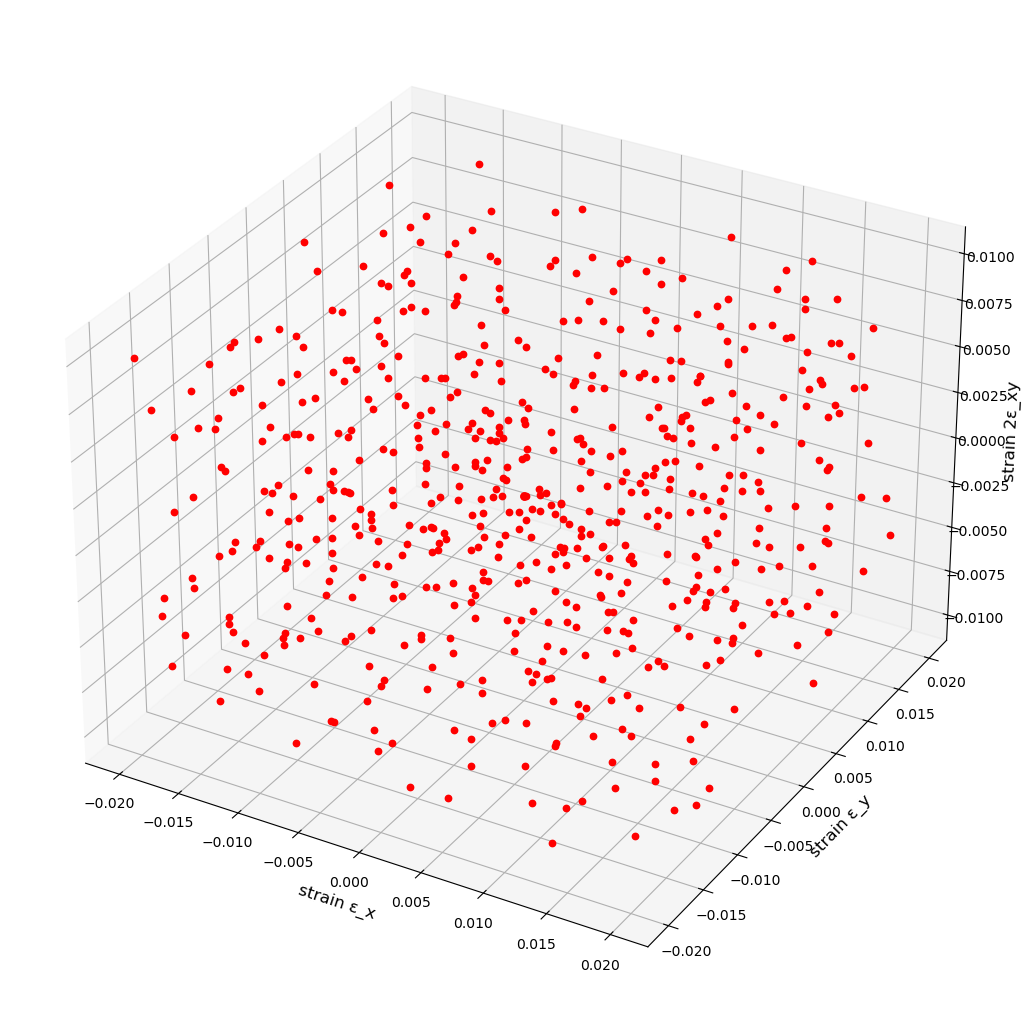

594

In [6]:
inherit = True  # 是否用继承的坐标启动

num_strain = 10  # 每个构型上的随机应变
random_select = 10  # 从随机应变中挑选的个数，施加在构型上的实际应变
all_model_rotate = 27  # 所有的构型
max_strain = 0.04
strain_box = max_strain * np.array([[-1, 1], [-1, 1], [-1, 1]])  # 应变范围 [ε_x ε_y 2ε_xy]
strain_box[2] = strain_box[2] / 2  #

strain_matrix, strain_matrix_d = generate_strain_matrix(
    num_strain,
    all_model_rotate,
    strain_box,
    random_select=random_select,
    inherit=inherit,
    dict_name=strain_value_dict,
    array_name=strain_value_list,
)
# %matplotlib auto
# plt.show(block=True)
test_dict_plot(strain_matrix_d)

len(strain_matrix_d.keys())

In [7]:
strain_matrix.shape

(27, 22, 3)

## 3.2 strain bulk

In [8]:
refer_bulk_l = get_bulk_set(bulk, strain_matrix)
refer_bulk_d = array2dict(refer_bulk_l)

out_car_list(refer_bulk_l, path=refer_bulk_folder)

shutil.copy(strain_value_dict, refer_bulk_folder)  # 对应的应变记录文件
shutil.copy(strain_value_list, refer_bulk_folder)

'/media/zwbai/DATA/dft/all_copy/output/refer_bulk/strain_matrix.npy'

## 3.3 strain slab 

In [9]:
exist_folder(refer_bulk_copy)  # 计算完成后，确保计算结果存在
# 复制CONTCAR文件到目标目录，执行操作，并改名为POSCAR
# 该方法直接从优化后的bulk创建了slab
poscar_files = copy_contcar(refer_bulk_copy, refer_slab_folder, func=operate)

folder '/media/zwbai/DATA/dft/all_copy/input/refer_bulk_cal' exists


get model from bulk to slab after calculation completed.

In [10]:
exist_folder(refer_slab_copy)
strain_slabs_l, strain_slabs_d = read_cars(refer_slab_copy)  # 有应变的基底

folder '/media/zwbai/DATA/dft/all_copy/input/refer_slab_cal' exists
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018

# 4. Adsorbed molecule

## 4.1 atom positions

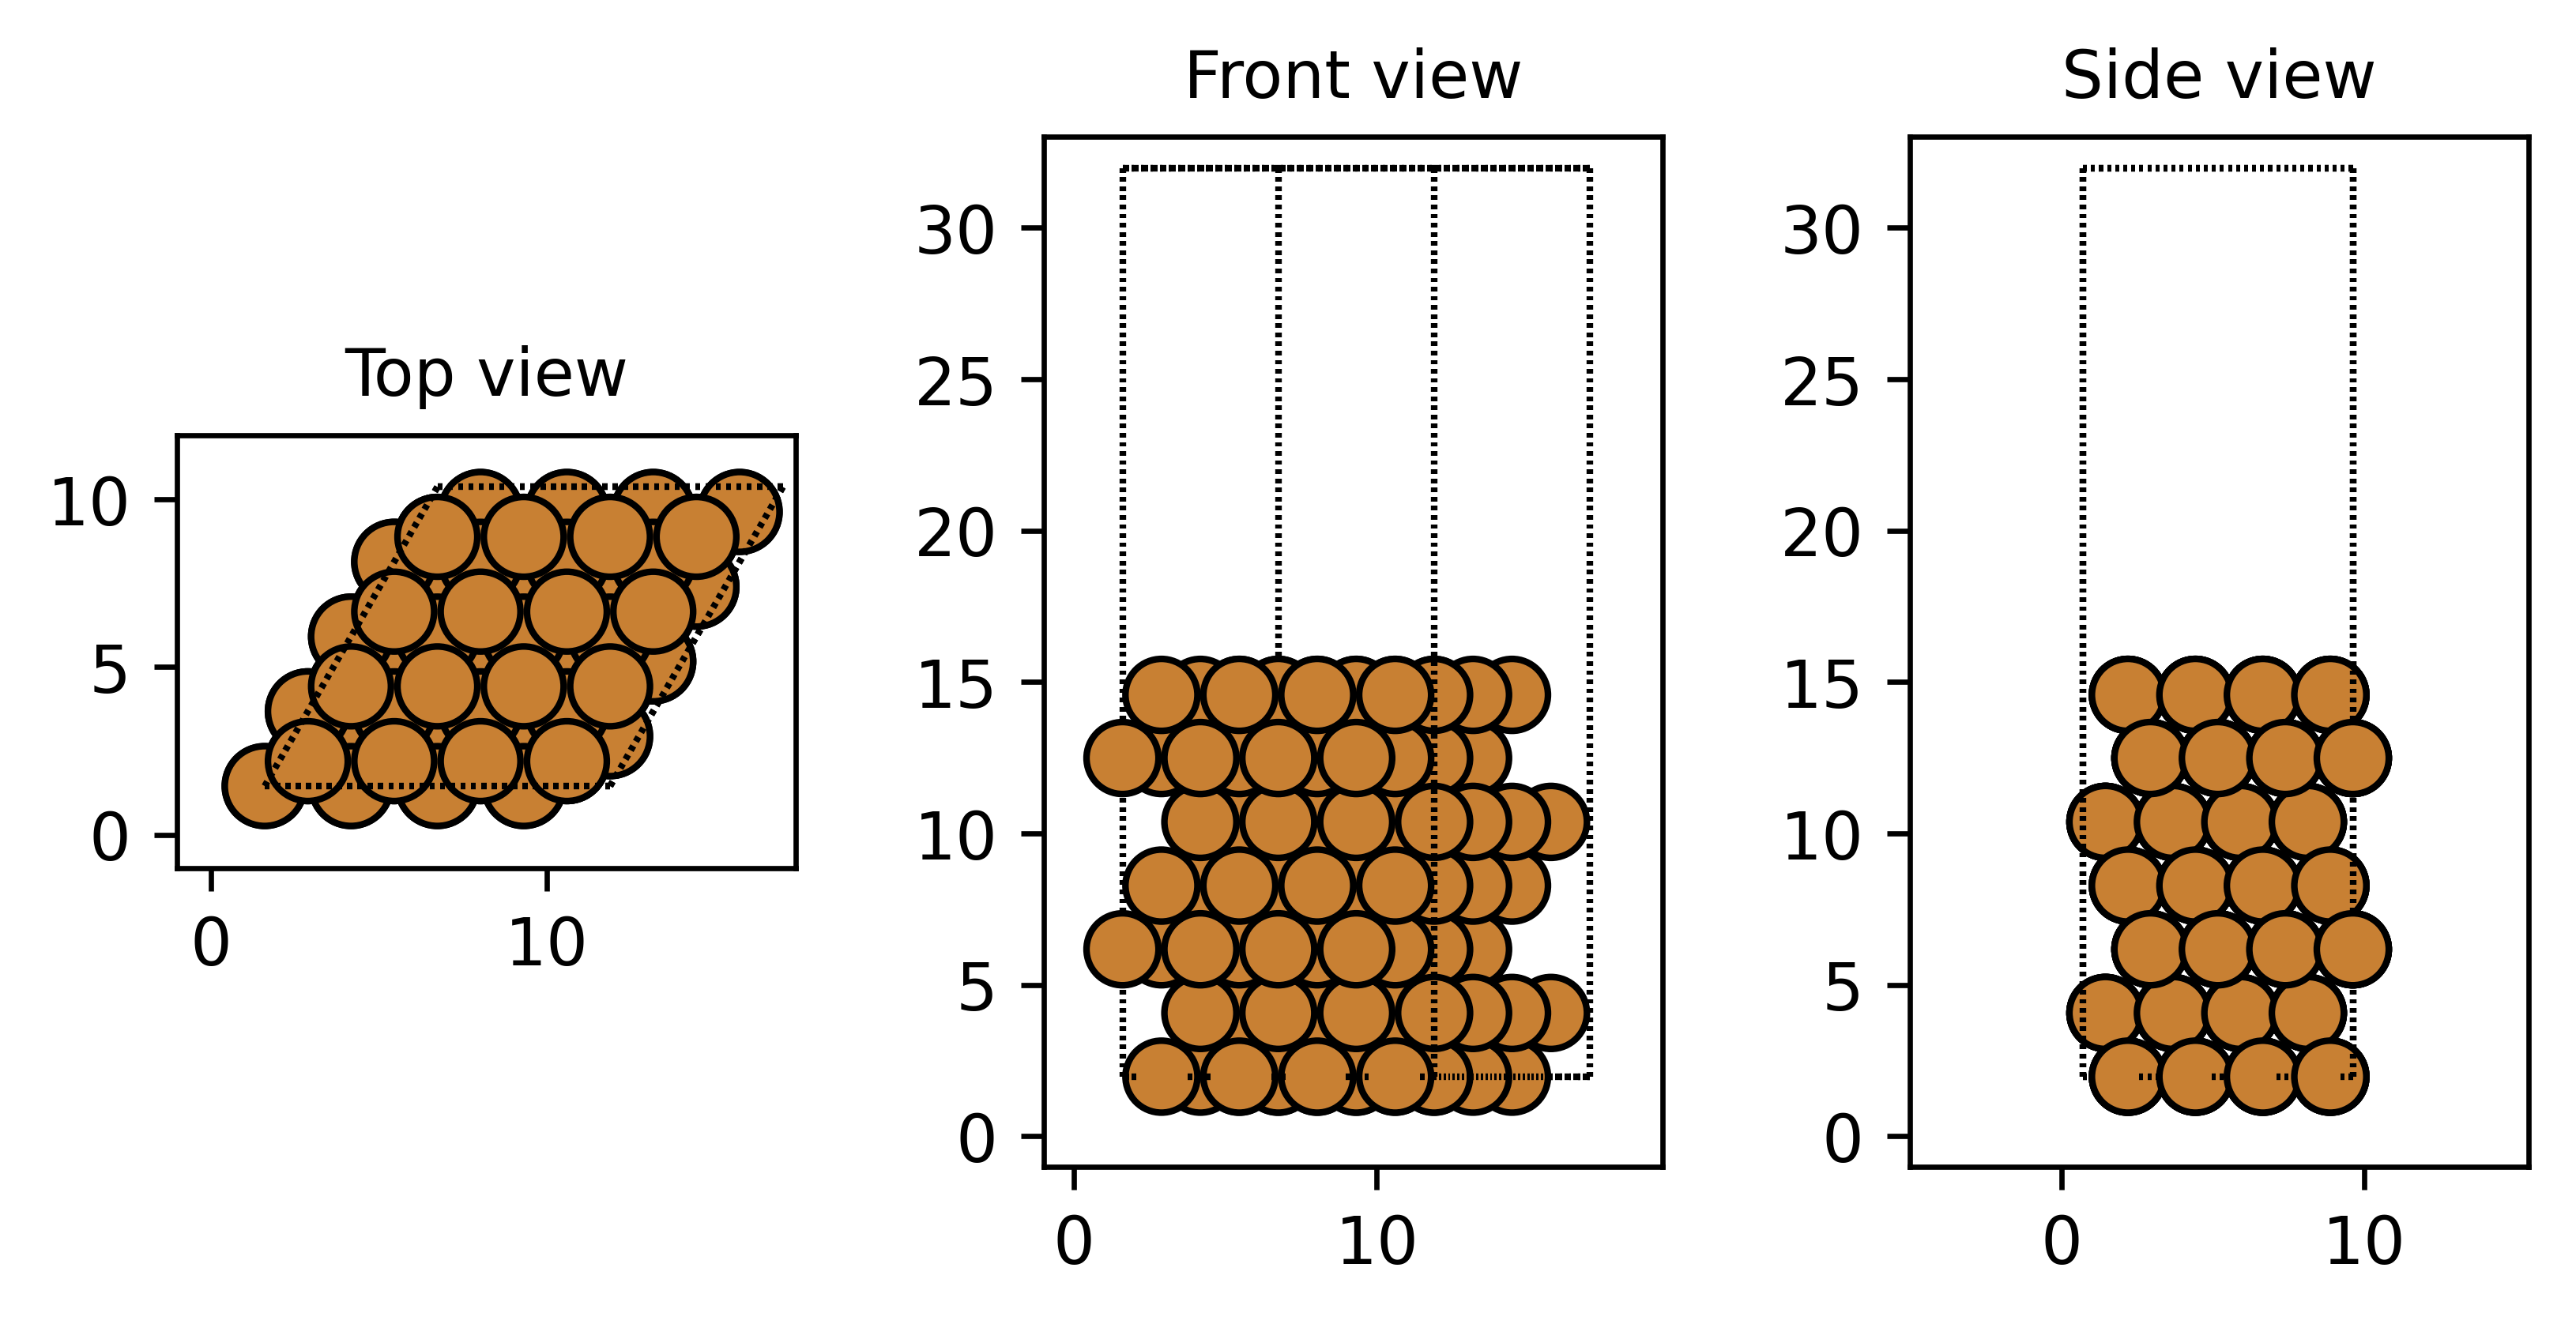

[FixAtoms(indices=[0, 1, 2, 3, 4, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 35, 36, 37, 38, 39, 42, 43, 44, 45, 46, 49, 50, 51, 52, 53, 56, 57, 58, 59, 60, 63, 64, 65, 66, 67, 70, 71, 72, 73, 74, 77, 78, 79, 80, 81, 84, 85, 86, 87, 88, 91, 92, 93, 94, 95, 98, 99, 100, 101, 102, 105, 106, 107, 108, 109]), FixCartesian(a=[5, 6, 12, 13, 19, 20, 26, 27, 33, 34, 40, 41, 47, 48, 54, 55, 61, 62, 68, 69, 75, 76, 82, 83, 89, 90, 96, 97, 103, 104, 110, 111], mask=[True, True, False])]
[0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0
 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2 0 0 0 0 0 1 2]


In [11]:
slab_op.set_constraint()  # 清除约束
adslab = slab_op.copy()
adslab = adslab.repeat((4, 4, 1))
adslab = set_cons0(adslab)
plot_model(adslab)
print(adslab.constraints)
print(adslab.get_tags())
out_poscar(adslab, path=Cu_slab4_folder)  # 放大的基底

In [12]:
exist_folder(Cu_slab4_copy)
adslab = read_one_car(Cu_slab4_copy)
adslab = set_cons1(adslab)
print(adslab.constraints)
print(adslab.get_tags())
print(len(adslab) - len(adslab.constraints[0].index))  # 有几个原子没有约束
# out_poscar(adslab1, path = './vasp_cala/Cu_slab4') # 放大的基底

folder '/media/zwbai/DATA/dft/all_copy/input/Cu_slab4_copy' exists
[FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110])]
[ 0  0  0  0  0  1 -1  0  0  0  0  0  1 -1  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1 -1  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0
  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0  0  0  0  0  1  2  0
  0  0  0  0  1  2]
13


In [13]:
top3d_index = [
    [10, 11, 14, 15],
    [10, 11, 14, 7],
    [10, 11, 14, 13],
]  # 重要 是三种旋转坐标的参考原子在顶层的序号

top3d = get_top3d_rotate(adslab, top3d_index)
top3d

[[76, 83, 104, 111], [76, 83, 104, 55], [76, 83, 104, 97]]

[ 9.0001  5.1962 14.4157]
[ 9.643   6.3097 14.1677]
[10.2859  5.9385 14.1169]
[11.5716  6.6809 14.1171]


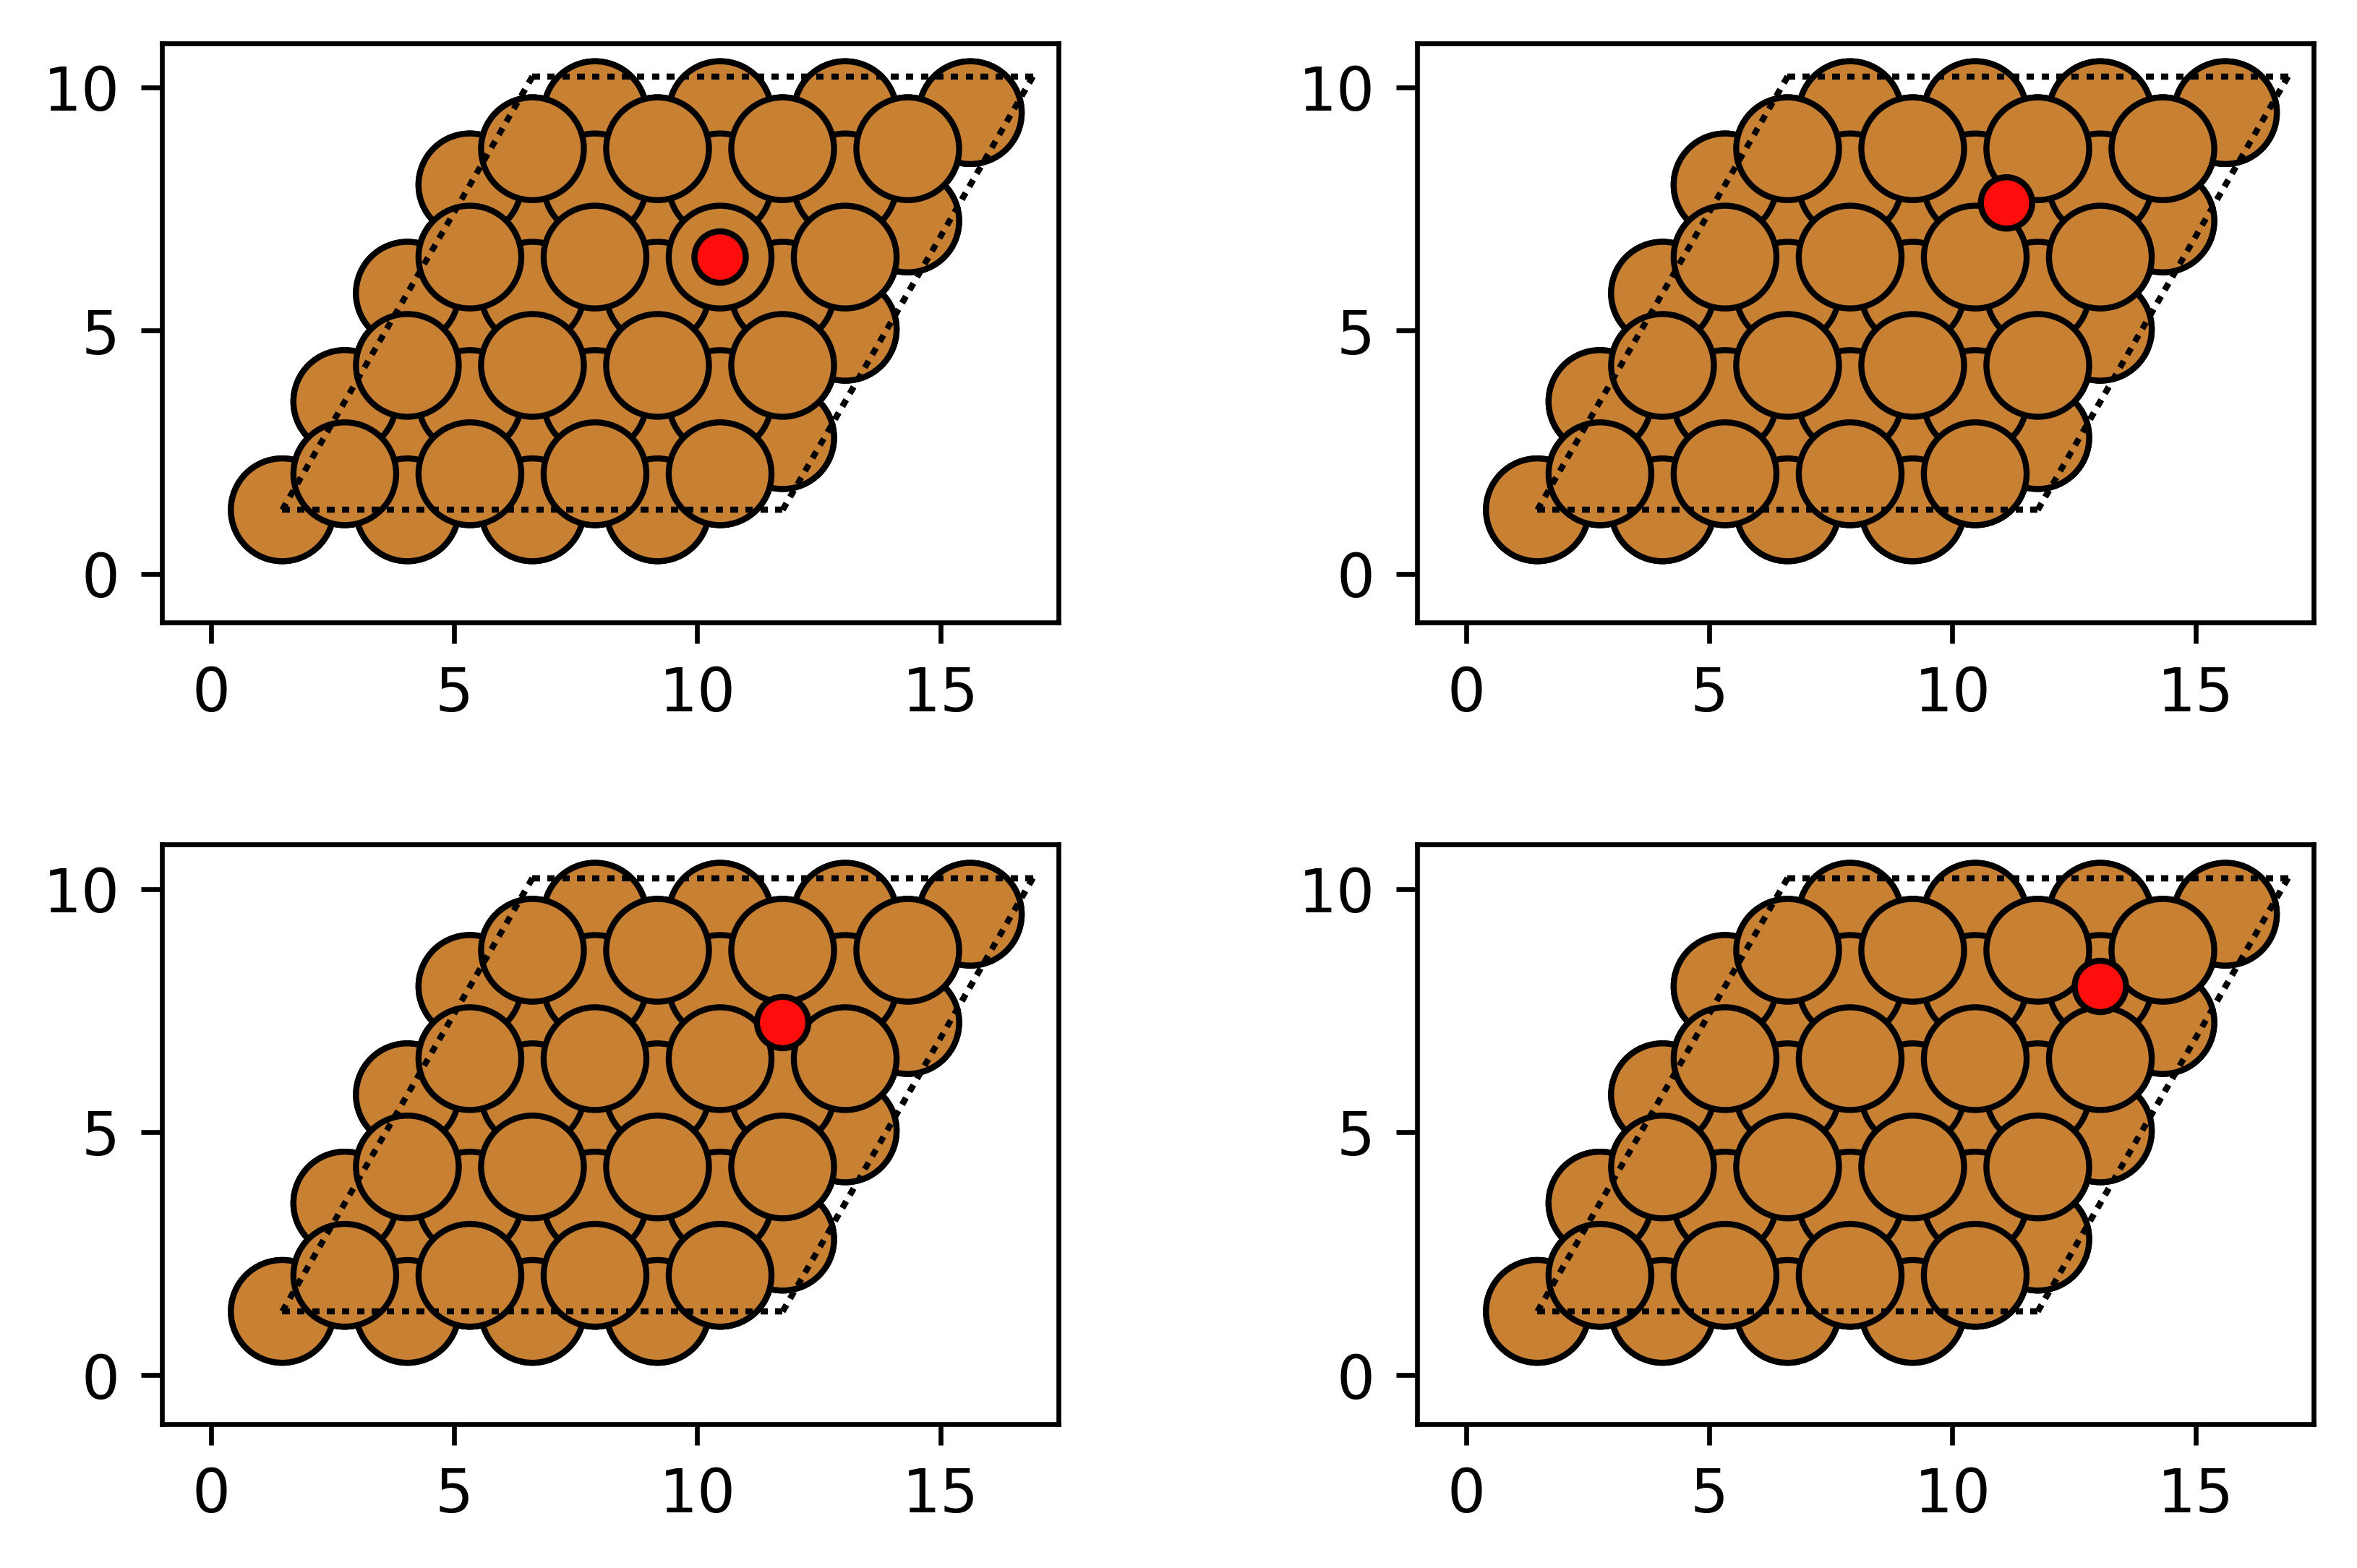

In [14]:
order = ["top_0", "bri_12", "hol_012", "hol_123"]
atom_model_l, atom_model_d = get_atom_adsmodel(adslab, top3d[0], order=order)
plot_top(atom_model_l, column=2)
# folder_path = "./vasp_cala/one_atoms/"
out_poscar(atom_model_d, path=one_atom_folder)  # 新的单原子构型

1st dict_keys(['bri_12', 'hol_012', 'hol_123', 'top_0'])


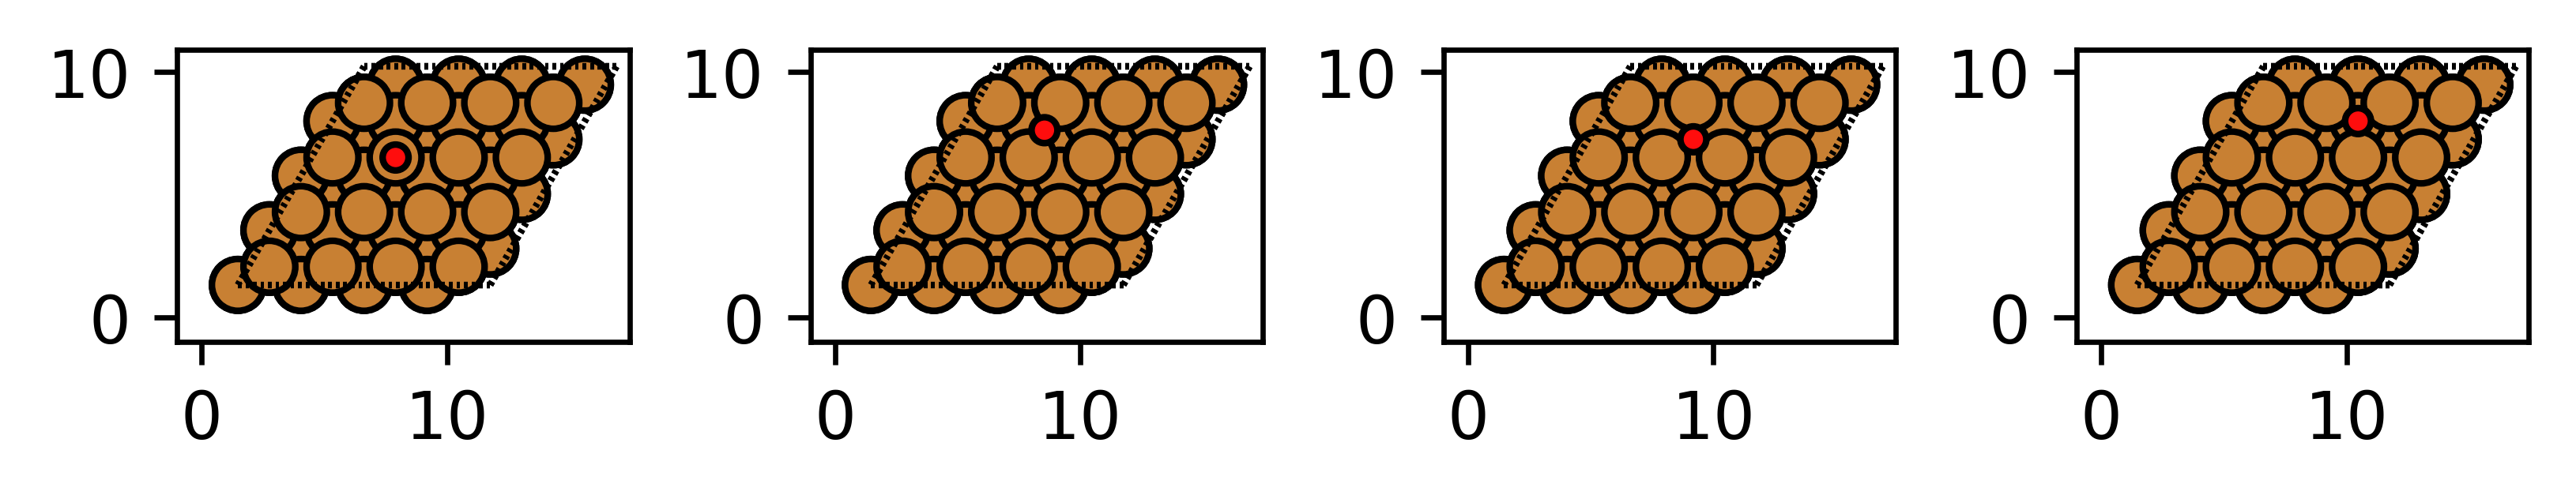

In [15]:
one_atoms_l, one_atoms_dict = read_car(
    one_atom_copy, car="CONTCAR"
)  # car = 'CONTCAR'
one_atoms_l = [one_atoms_dict[i] for i in order]
plot_top(one_atoms_l, column=4)

In [16]:
[
    one_atoms_l[i].get_positions()[-1, -1] for i in range(len(one_atoms_l))
]  # 单原子z方向的高度

[14.308458547612775, 13.890649479568673, 13.755736412769938, 13.76762035462312]

## 4.2 molecule positions

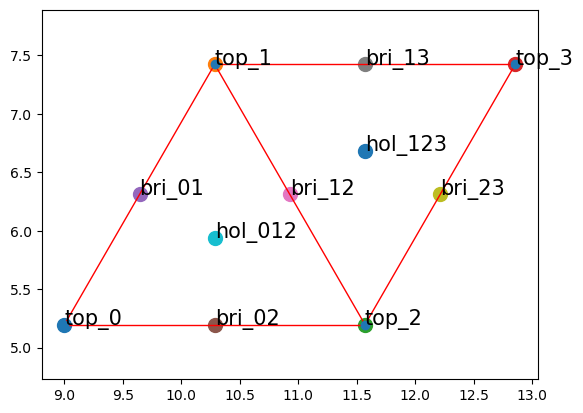

In [17]:
mel_d = get_dic(adslab, one_atoms_l)  # 每个点的坐标
molecule_name = [
    ["top_0", "top_1"],  # 0-2
    ["top_0", "bri_12"],  # 3-5
    ["top_0", "hol_123"],  # shear2 6-8
    ["top_0", "hol_012"],  # 9-11
    ["hol_012", "bri_23"],  # shear 4 12-14
    ["hol_123", "bri_02"],  # shear2 5 15-17
    ["hol_012", "hol_123"],  # 18-20
    ["bri_02", "bri_13"],  # shear 7 21-23
    ["bri_02", "bri_12"],  # 24-26
]  # 吸附分子的两个原子的吸附位置
mol = np.zeros([len(molecule_name), 2, 3])  # 储存三维点坐标
for i in range(len(molecule_name)):
    mol_o2 = np.array([mel_d[molecule_name[i][0]], mel_d[molecule_name[i][1]]])
    mol[i] = mol_o2

In [18]:
molecule_model = get_molecule_adslab(adslab, mol)

[14.3085 14.3085]
[14.3085 13.8906]
[14.3085 13.7676]
[14.3085 13.7557]
[13.7557 13.8906]
[13.7676 13.8906]
[13.7557 13.7676]
[13.8906 13.8906]
[13.8906 13.8906]


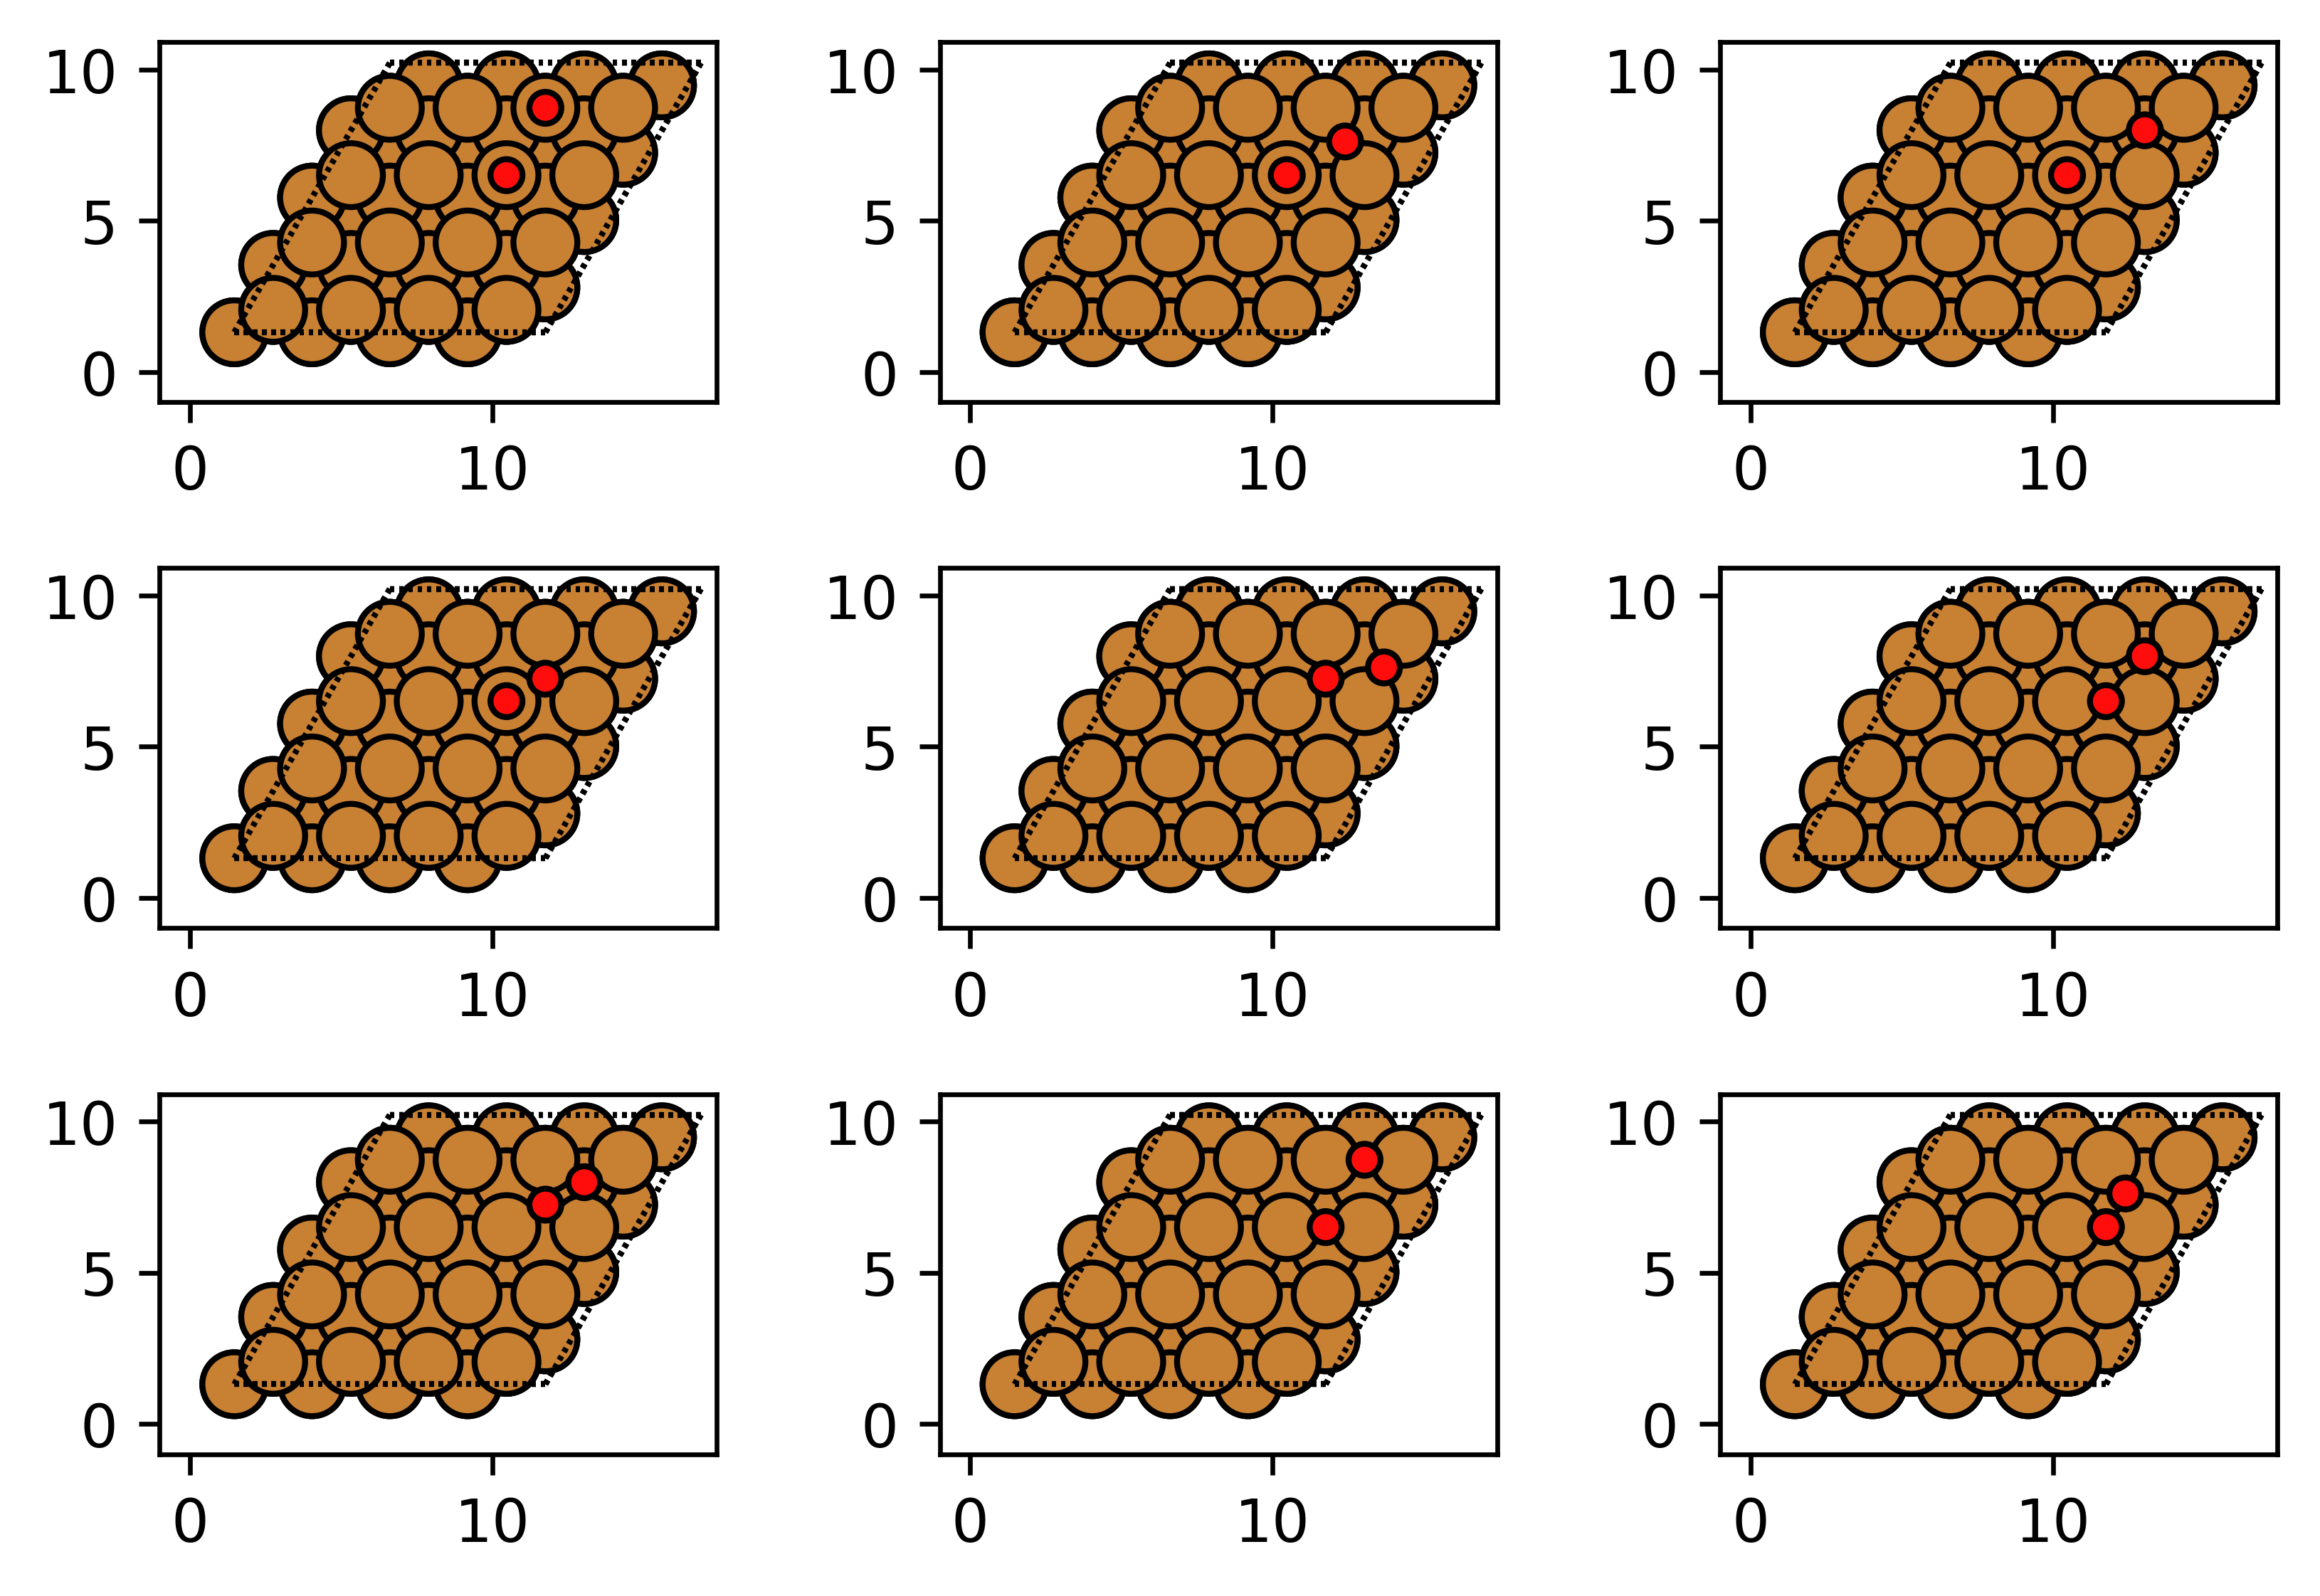

In [19]:
out_poscar(molecule_model, nostrain_molecule_folder)
plot_top(molecule_model, column=3)

wait calculation complete

In [20]:
molecule_model_relax_l, molecule_model_relax_d = read_car(
    nostrain_molecule_copy, car="CONTCAR"
)  # car='CONTCAR'

1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008'])


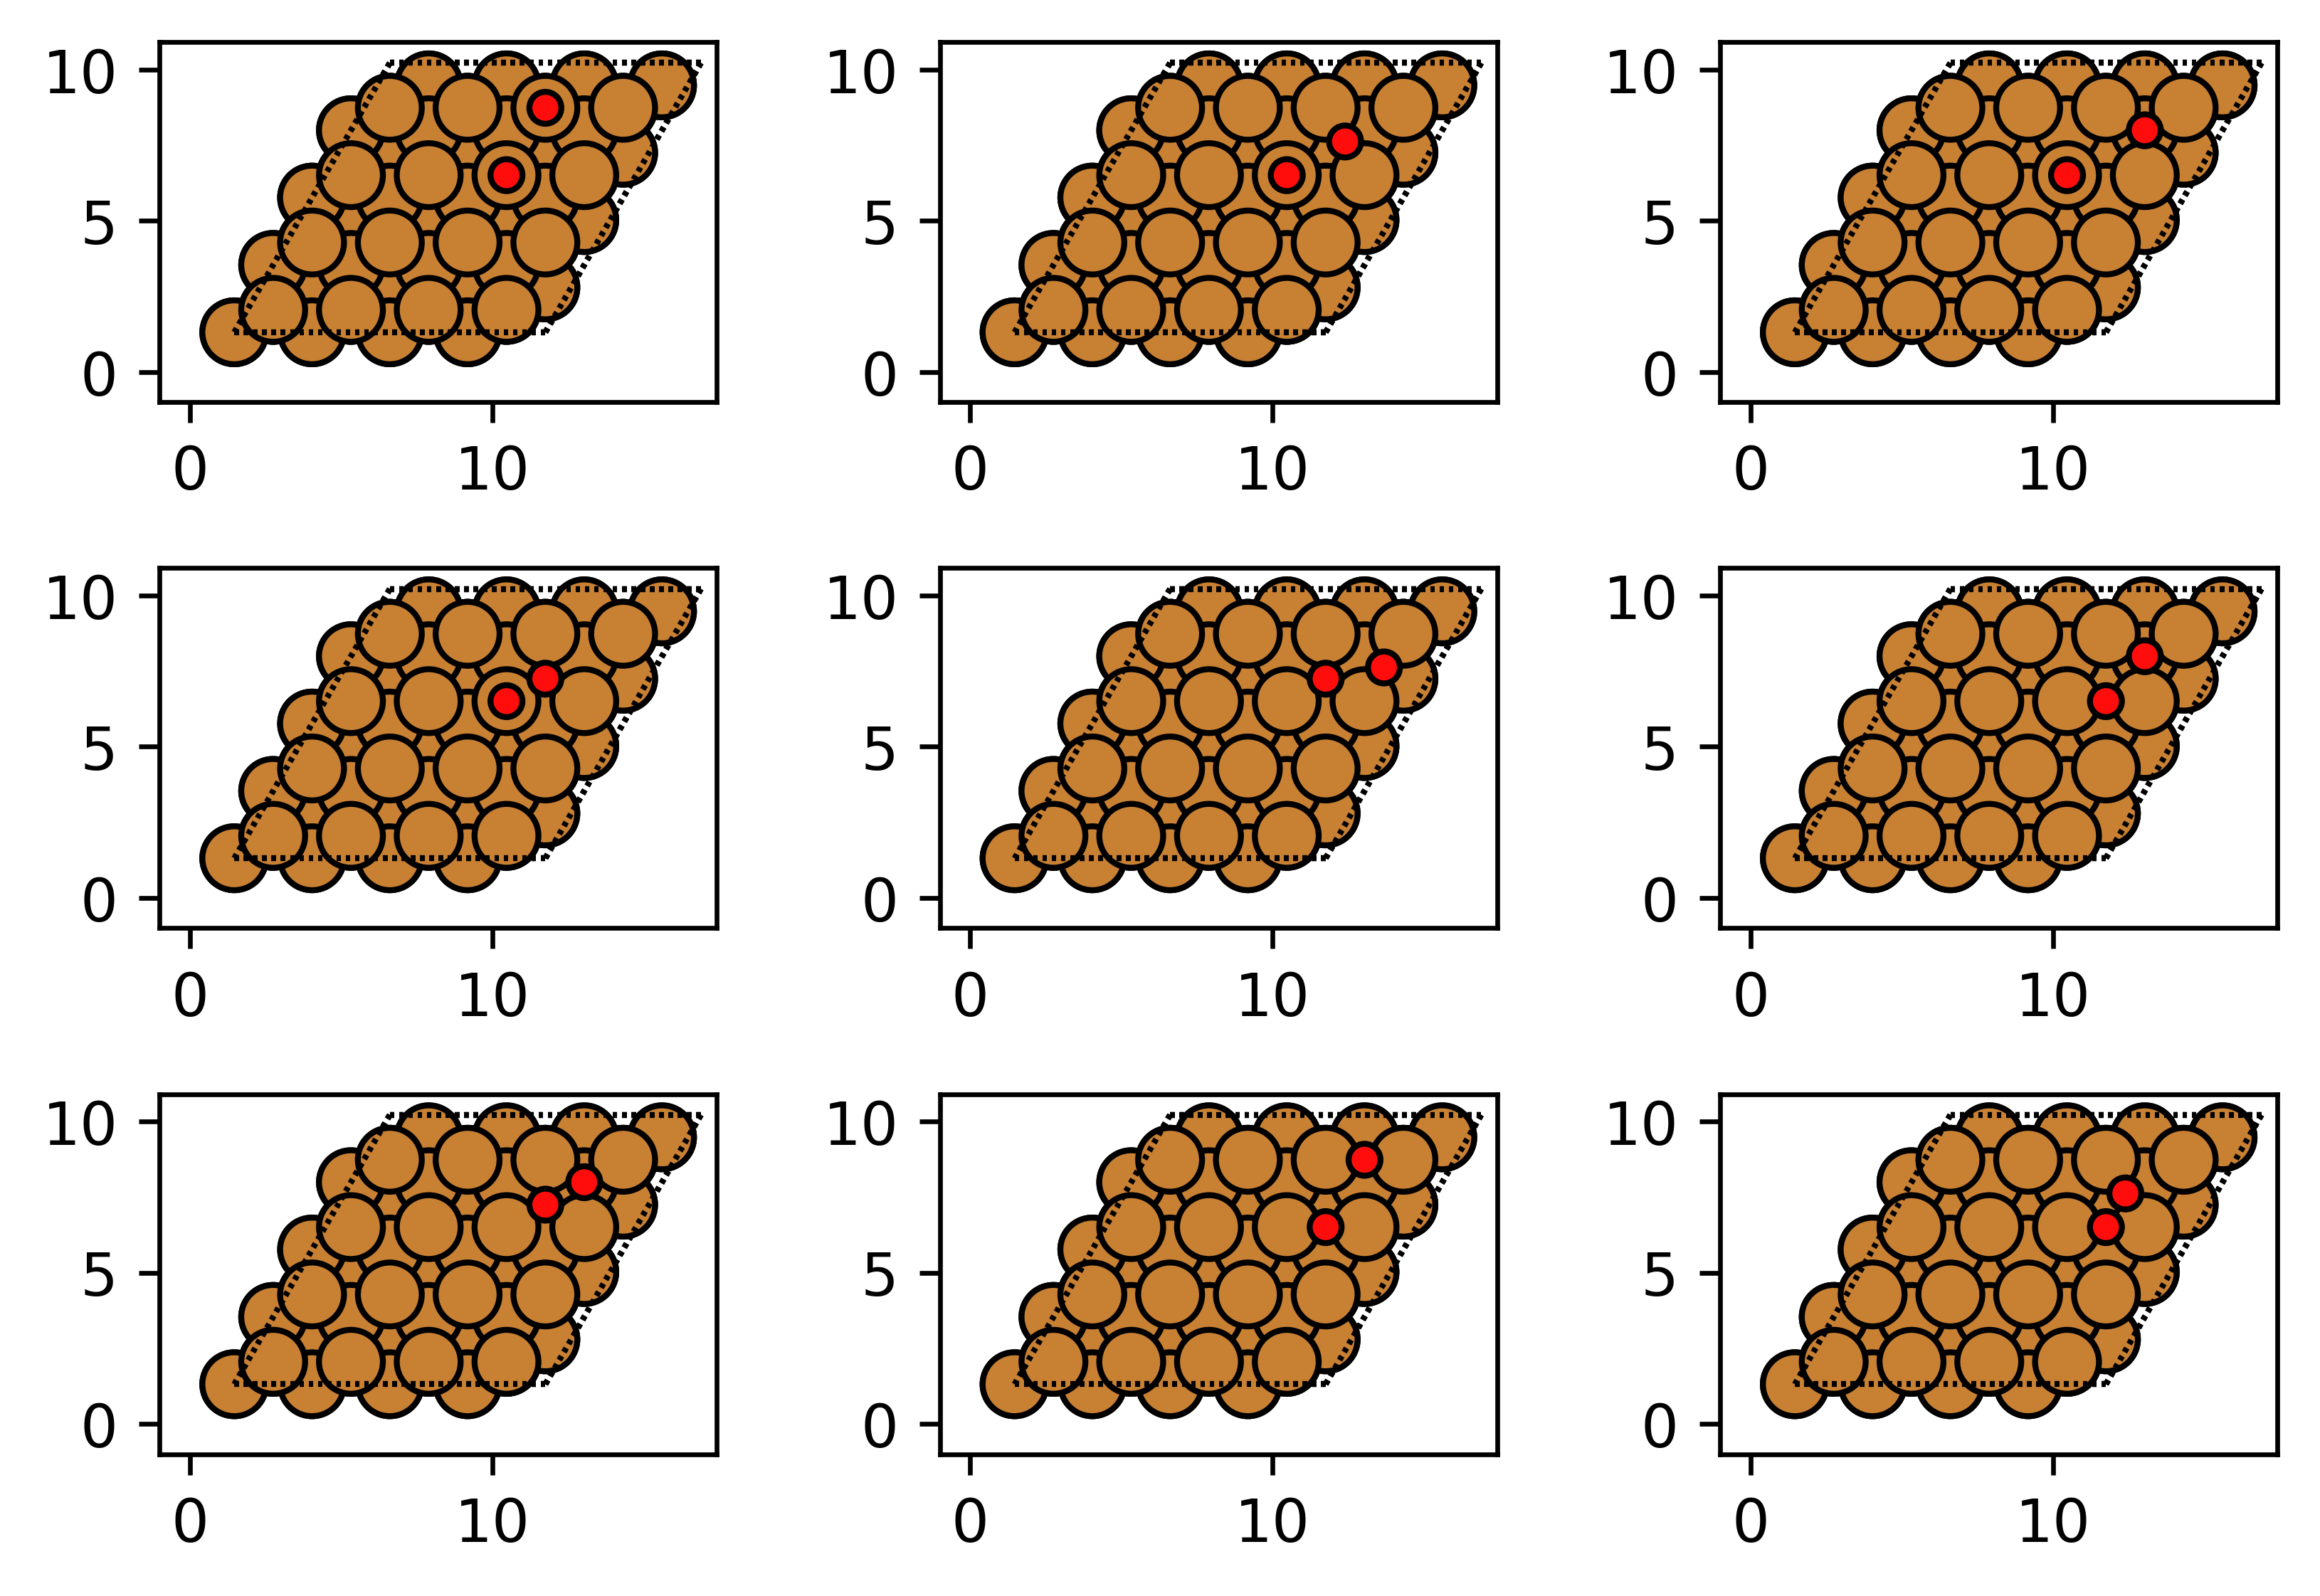

In [21]:
plot_top(molecule_model_relax_l, column=3)

In [22]:
molecule_energy_relax_l, molecule_energy_relax_d = read_car(
    nostrain_molecule_copy, car="OSZICAR"
)

E0 value: -1 F   -.41152881E+03
E0 value: -1 F   -.41238936E+03
E0 value: -1 F   -.41347738E+03
E0 value: -1 F   -.41263940E+03
E0 value: -1 F   -.41329765E+03
E0 value: -1 F   -.41322994E+03
E0 value: -1 F   -.41269243E+03
E0 value: -1 F   -.41402914E+03
E0 value: -1 F   -.41252577E+03
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008'])


## 4.3 Rotate

Asymmetric strain can cause configuration asymmetry

In [23]:
molecule_d = {}
for i in range(len(molecule_name)):
    molecule_text = f"{molecule_name[i][0]}_{molecule_name[i][1]}"
    molecule_d[molecule_text] = molecule_model_relax_l[i]

mol_rotate_d = {}
axis = mel_d["hol_012"]
axis = axis[:2]
for key, r in itertools.product(molecule_d, range(3)):
    ra = 120 * (r)  # rotate angle
    # print(molecule_dic[key])
    adslab0 = molecule_d[key].copy()
    xypos = adslab0.positions[-2:, :2]
    xypos = rotate_point(xypos, axis, angle=ra)
    adslab0.positions[-2:, :2] = xypos
    mol_rotate_d[f"{key}_{str(ra)}"] = adslab0
len(mol_rotate_d)
mol_rotate_l = list(mol_rotate_d.values())

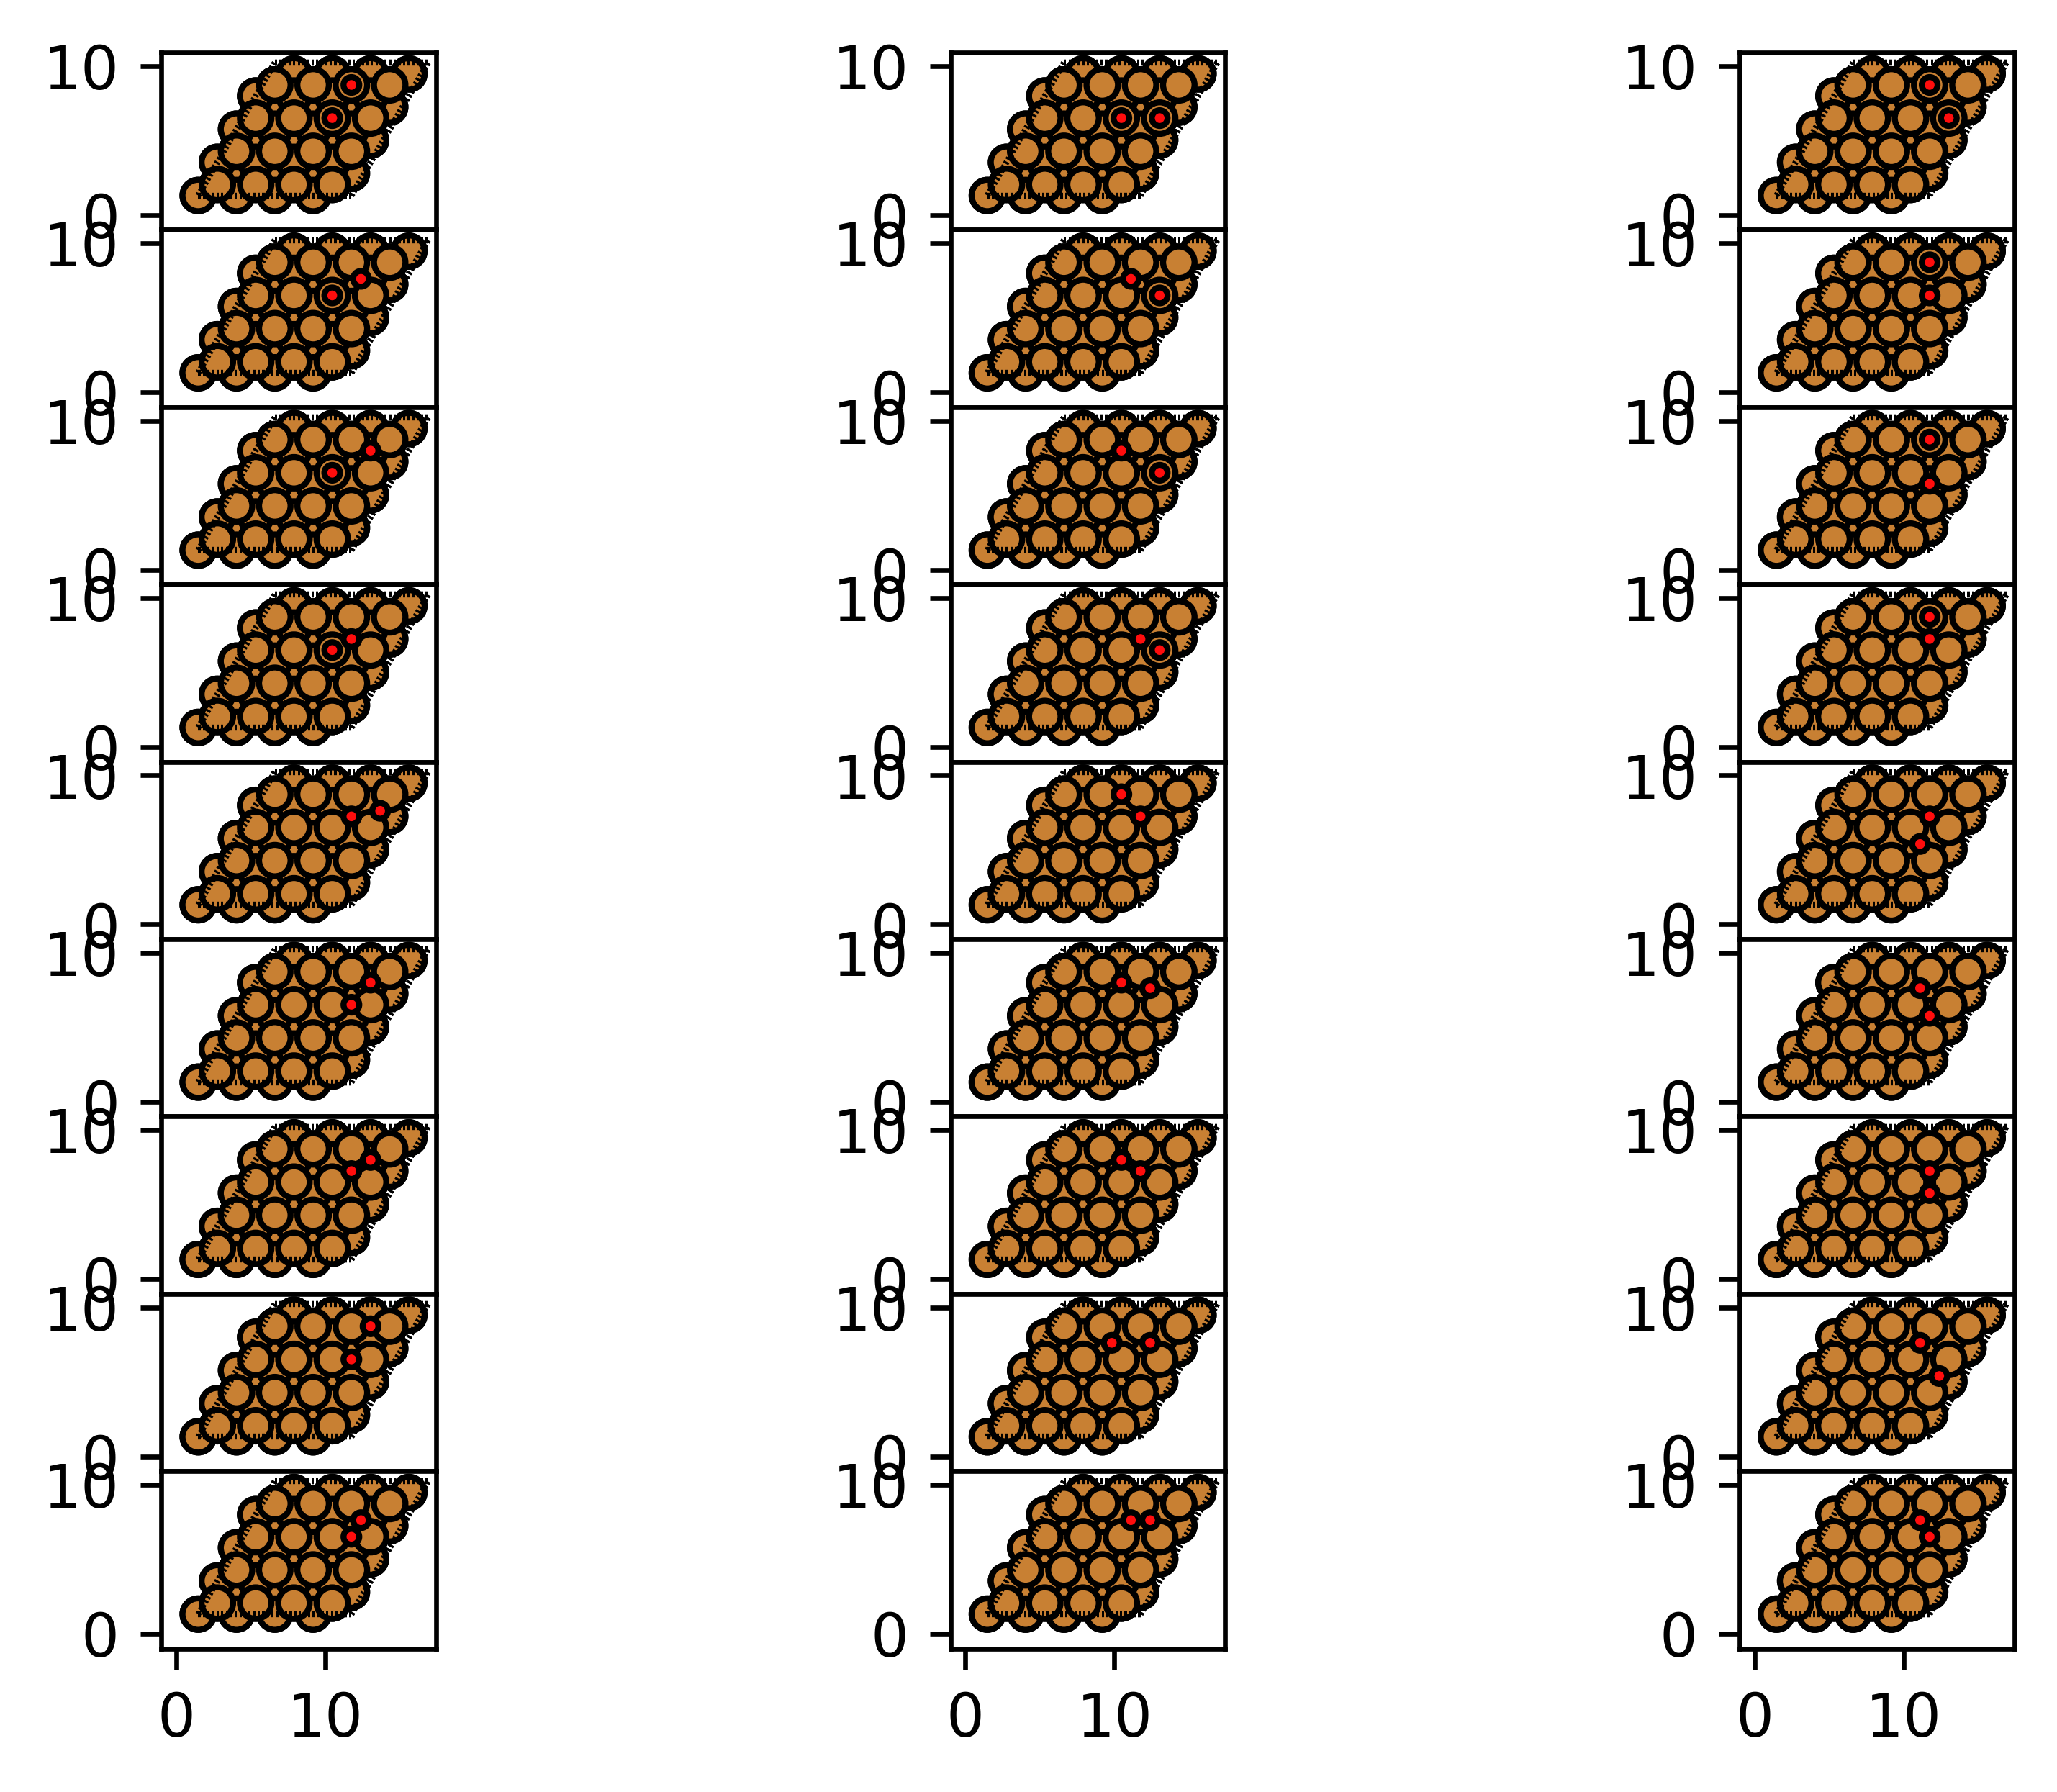

In [24]:
plot_top(mol_rotate_l, column=3)
# out_poscar(mol_rotate_dic, path="./vasp_cala/nostrain_molecule3")

# 5. Set strain
There should be four processes: 

① applying strain to the bulk, executing optimization; 

② cutting out the slab, executing optimization; 

③ adsorbing molecules, executing optimization

Firstly, there should be the results of the above process with a no strain slab as a reference

## 5.1 Strain free configuration reference

In [25]:
mol_rotate_l = list(mol_rotate_d.values())

需要构建吸附的（分子）两个原子和基底表面原子的对应关系。这个关系在 应变映射吸附分子初步推断起作用。

无应变吸附构型 和 有应变slab构型 推断 有应变吸附构型
可以认为与通道内的原子相关

In [26]:
sort_nei_d = {}
for index, (key, adsalbi) in enumerate(mol_rotate_d.items()):
    # adsalbi.set_constriant()
    rot = int(int(key.split("_")[-1]) / 120) # 共3个角度
    top1d = top3d[rot]
    adsi = adsalbi.get_positions()[-2:]
    fors = adsalbi[top3d[rot]].get_positions()
    rel = find_nearest_coordinate(adsi, fors)
    nei2 = []
    for j in rel:
        nei = [top1d[k] for k in j]
        nei2.append(nei)
    sort_nei_d[key] = nei2
    
sort_nei_l = list(sort_nei_d.values()) # 存储的是离吸附原子最近的基底原子
sort_nei_l

[[[76], [83]],
 [[104], [76]],
 [[83], [104]],
 [[76], [83, 104]],
 [[104], [76, 83]],
 [[83], [76, 104]],
 [[76], [83, 104, 111]],
 [[104], [76, 83, 55]],
 [[83], [76, 104, 97]],
 [[76], [76, 83, 104]],
 [[104], [76, 83, 104]],
 [[83], [76, 83, 104]],
 [[76, 83, 104], [104, 111]],
 [[76, 83, 104], [83, 55]],
 [[76, 83, 104], [76, 97]],
 [[83, 104, 111], [76, 104]],
 [[76, 83, 55], [83, 104]],
 [[76, 104, 97], [76, 83]],
 [[76, 83, 104], [83, 104, 111]],
 [[76, 83, 104], [76, 83, 55]],
 [[76, 83, 104], [76, 104, 97]],
 [[76, 104], [83, 111]],
 [[83, 104], [76, 55]],
 [[76, 83], [104, 97]],
 [[76, 104], [83, 104]],
 [[83, 104], [76, 83]],
 [[76, 83], [76, 104]]]

0


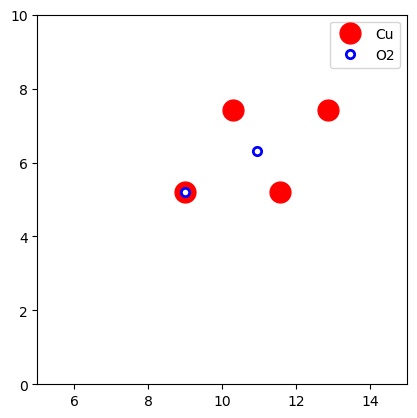

In [27]:
i = 3  # 校验通道和吸附原子的位置关系
keys = list(mol_rotate_d.keys())
key = keys[i]
adsalbi = mol_rotate_d[key]
# adsalbi.set_constriant()
rot = int(int(key.split("_")[-1]) / 120)
print(rot)

top1d = top3d[rot]
adsi = adsalbi.get_positions()[-2:]
fors = adsalbi[top3d[rot]].get_positions()
rel = find_nearest_coordinate(adsi, fors)
plot_points(fors[:, :2], adsi[:, :2])
nei2 = []
for j in rel:
    nei = [top1d[k] for k in j]
    nei2.append(nei)

In [28]:
strain_slabs_l2, strain_slabs_d2 = slab2slabs(strain_slabs_l)
strain_adslab = get_strain_adslab(mol_rotate_d, strain_slabs_d2, sort_nei_l)
# mol_rotate_d 中是包含了旋转的分子吸附构型

top_0_top_1_0
top_0_top_1_120
top_0_top_1_240
top_0_bri_12_0
top_0_bri_12_120
top_0_bri_12_240
top_0_hol_123_0
top_0_hol_123_120
top_0_hol_123_240
top_0_hol_012_0
top_0_hol_012_120
top_0_hol_012_240
hol_012_bri_23_0
hol_012_bri_23_120
hol_012_bri_23_240
hol_123_bri_02_0
hol_123_bri_02_120
hol_123_bri_02_240
hol_012_hol_123_0
hol_012_hol_123_120
hol_012_hol_123_240
bri_02_bri_13_0
bri_02_bri_13_120
bri_02_bri_13_240
bri_02_bri_12_0
bri_02_bri_12_120
bri_02_bri_12_240


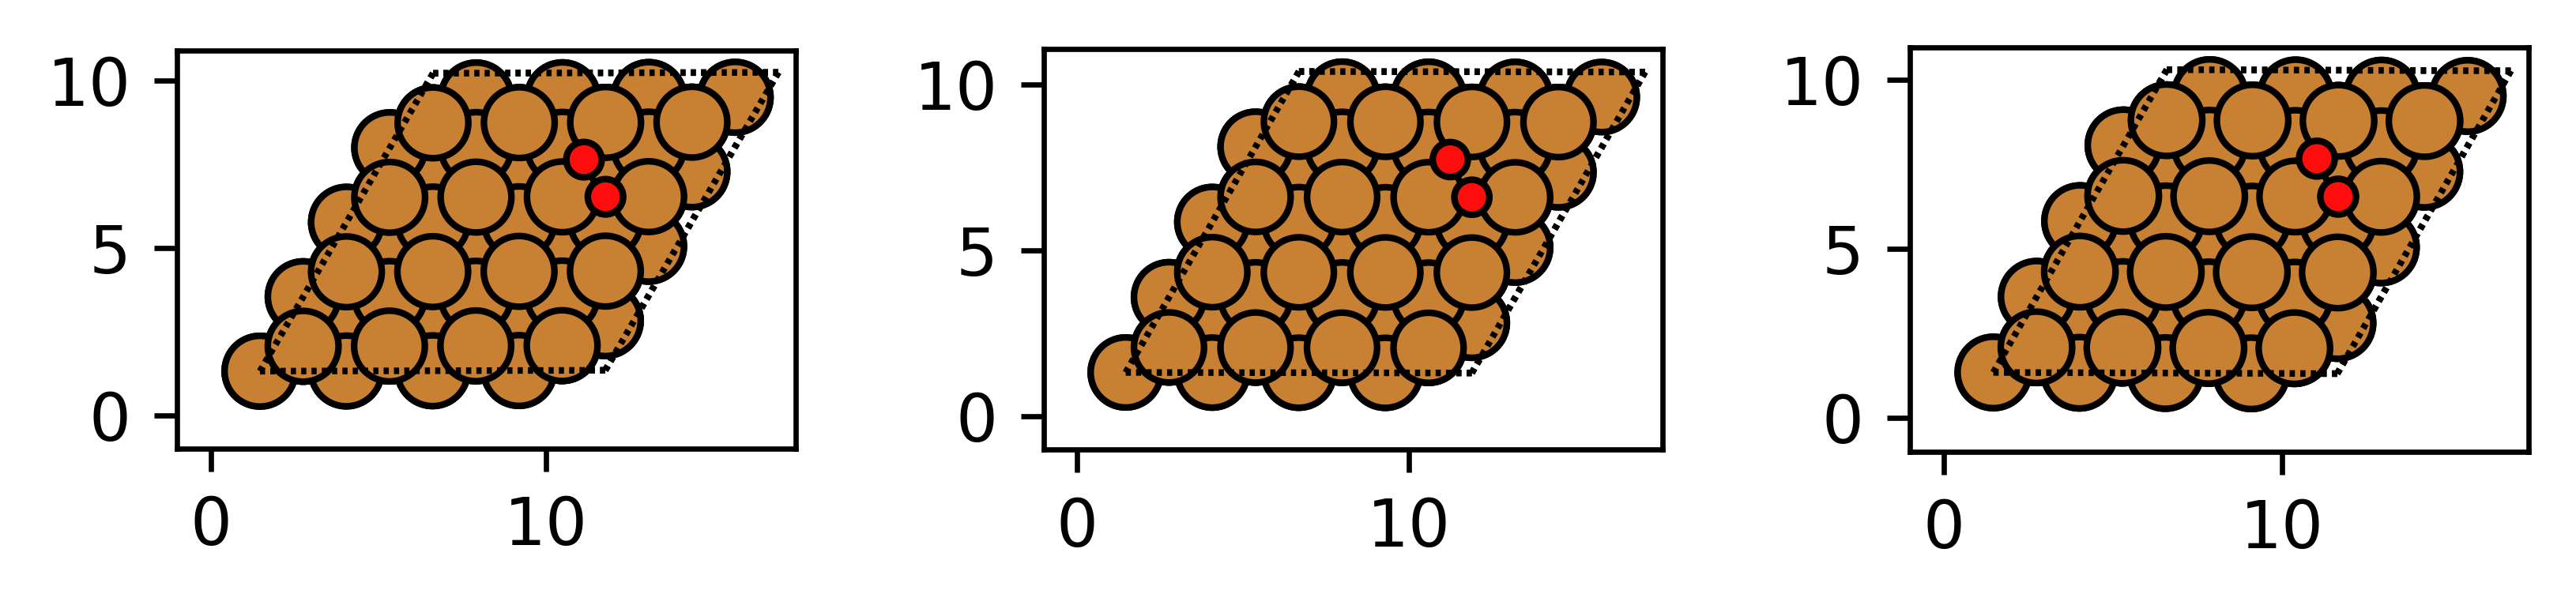

In [29]:
plot_top(strain_adslab[-1][:3])

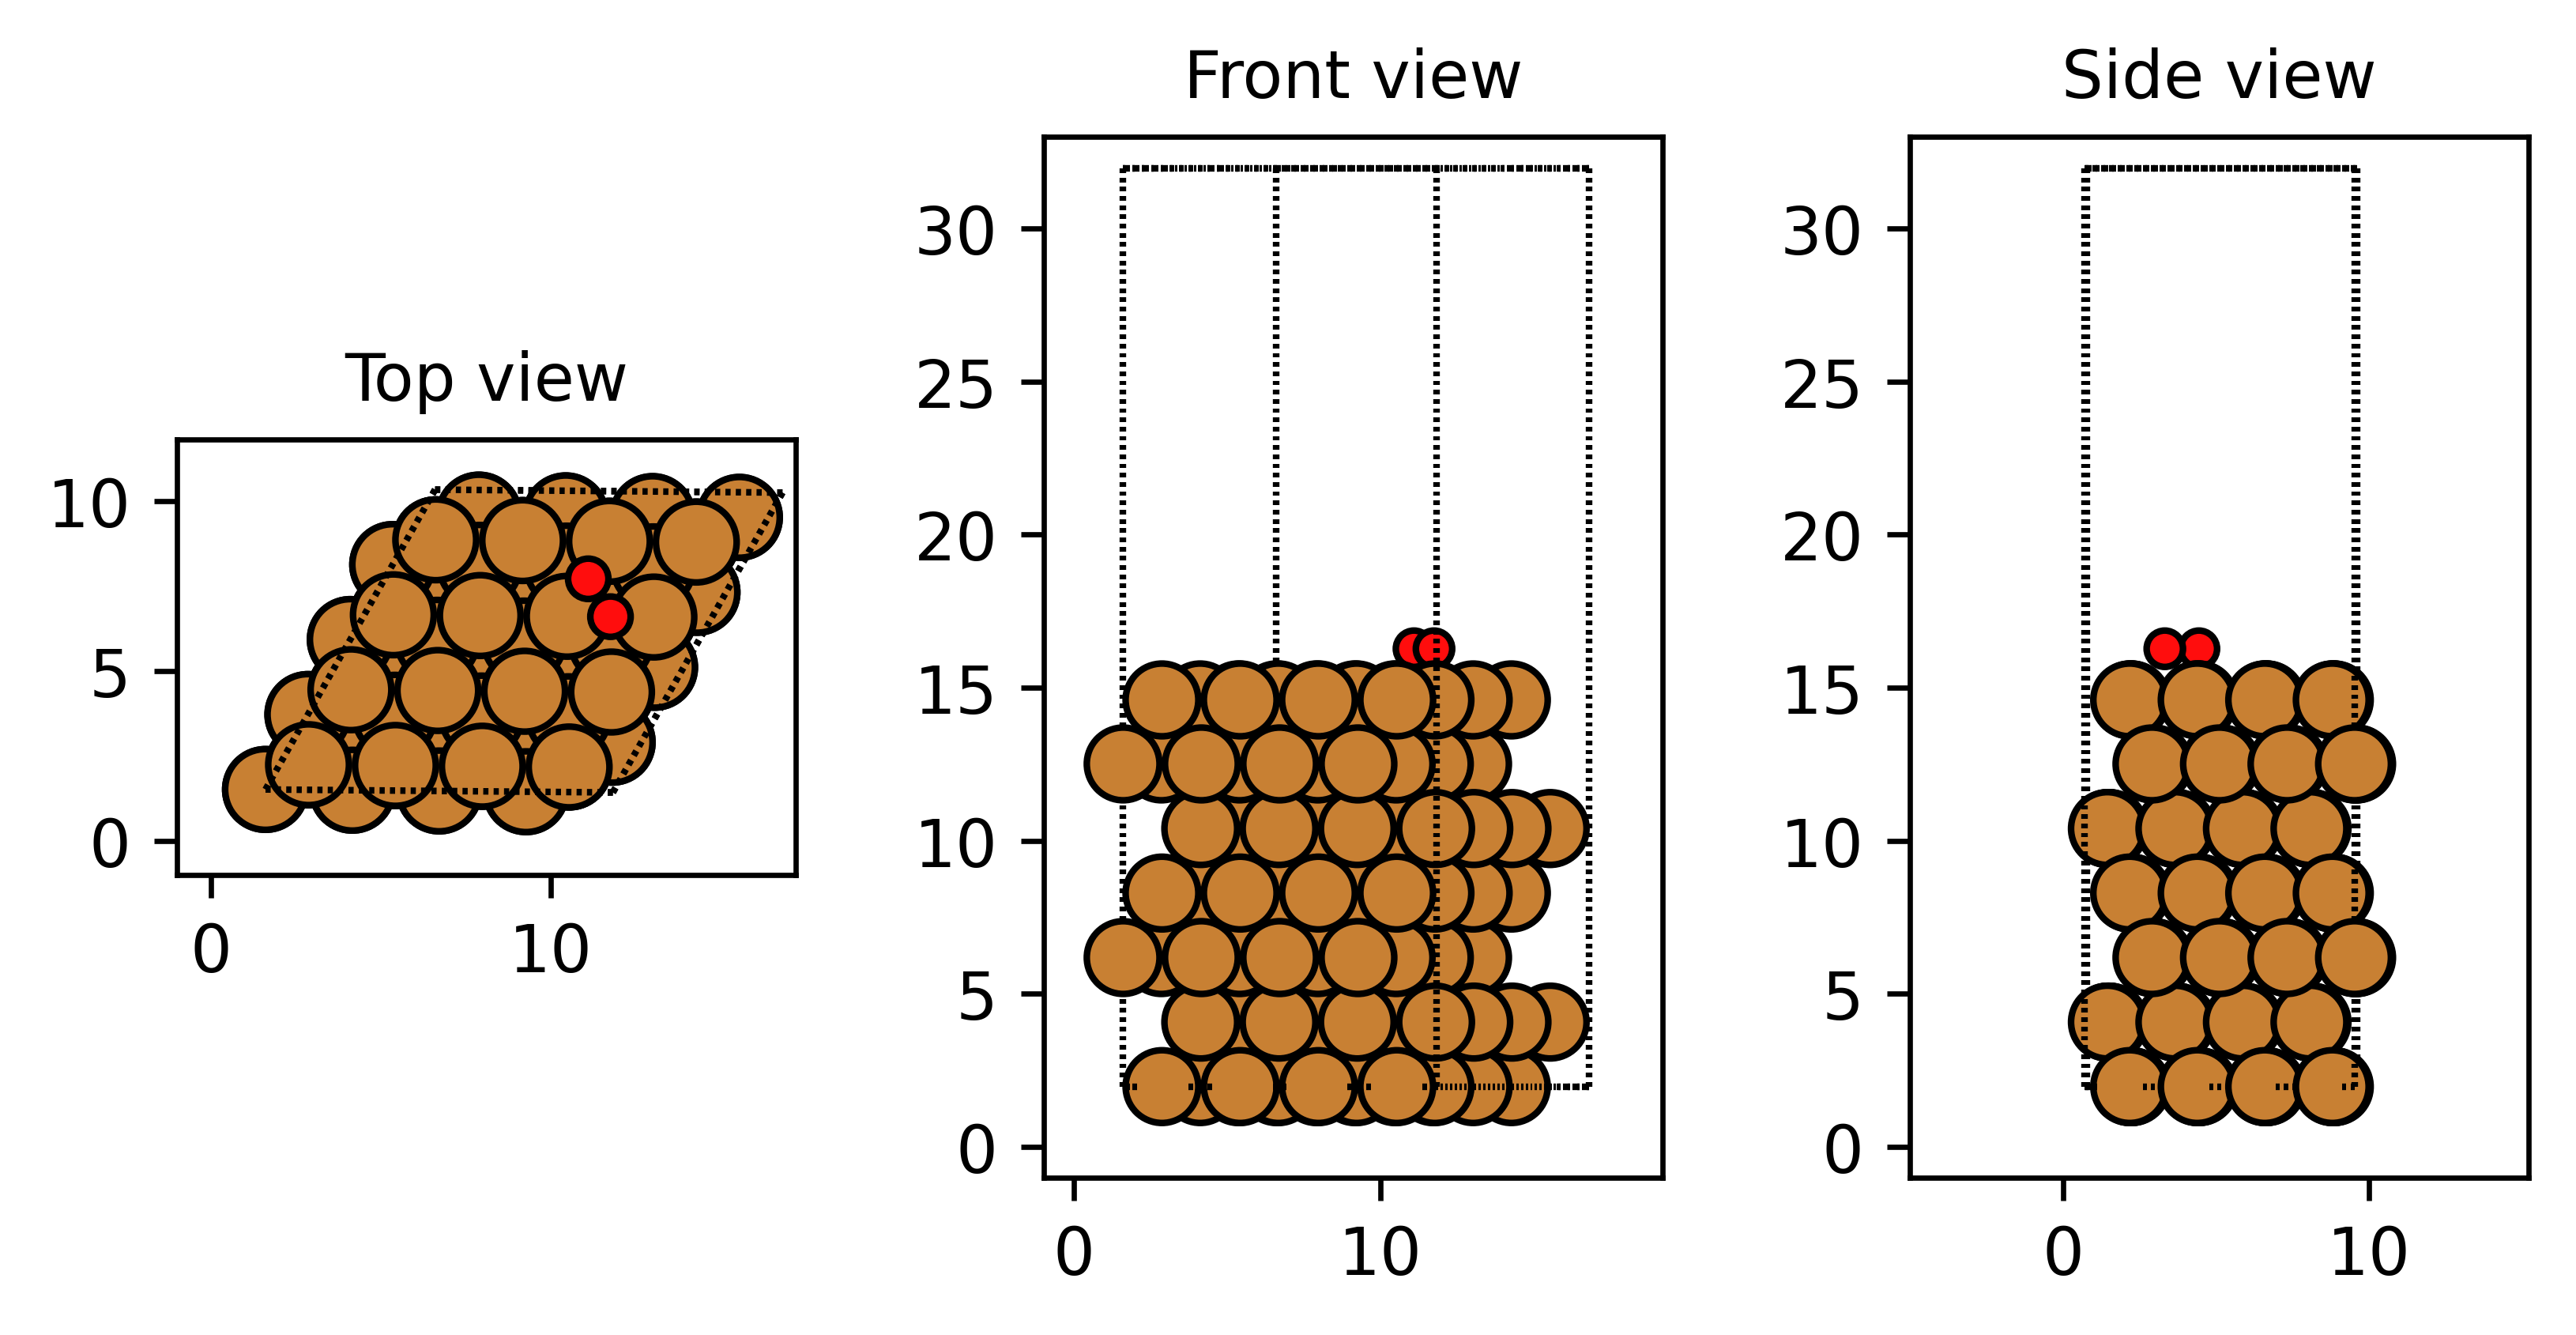

In [30]:
plot_model(strain_adslab[-1][-1])

In [31]:
out_car_list(strain_adslab, strain_adslab_folder)  # 最终的施加了应变的吸附结构

# 6. predict the impact of 3d strain 

In [32]:
max_strain = 0.02
strain_range = max_strain * 2
resolution = 0.005
strain_num = int(strain_range / resolution + 1)
pre_strain = np.zeros((strain_num, strain_num, strain_num, 3))
pre_strain.shape
for i in range(strain_num):
    for j in range(strain_num):
        for k in range(strain_num):
            strain = [i, j, k]
            strain = np.array(strain) * resolution - max_strain
            pre_strain[i, j, k] = strain

pre_strain[:,:,:,2] = pre_strain[:,:,:,2]/2
pre_strain = pre_strain.reshape((1, -1, 3))
pre_strain = np.tile(pre_strain, (9, 1, 1))
pre_strain.shape

(9, 729, 3)

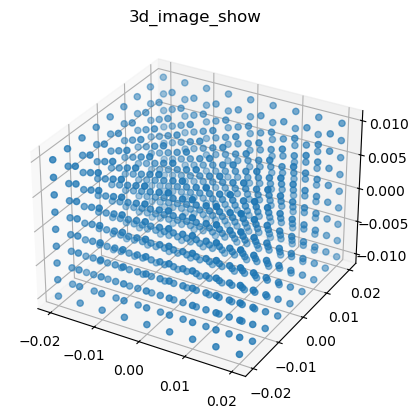

In [33]:
ax = plt.subplot(projection="3d")  # 创建一个三维的绘图工程
ax.set_title("3d_image_show")  # 设置本图名称
ax.scatter(pre_strain[0, :, 0], pre_strain[0, :, 1], pre_strain[0, :, 2])

plt.show()

In [34]:
pre_bulk_l = get_bulk_set(bulk, pre_strain)  # bulk上施加应变
pre_bulk_d = array2dict(pre_bulk_l)  # 转字典
pre_slab_l0 = bulk2slab(pre_bulk_l)  # 生成表面
pre_slab_l, pre_slab_d = slab2slabs(pre_slab_l0)  # 拓展

sort_nei0 = [sort_nei_l[i] for i in range(len(sort_nei_l)) if i % 3 == 0]
sort_nei0

[[[76], [83]],
 [[76], [83, 104]],
 [[76], [83, 104, 111]],
 [[76], [76, 83, 104]],
 [[76, 83, 104], [104, 111]],
 [[83, 104, 111], [76, 104]],
 [[76, 83, 104], [83, 104, 111]],
 [[76, 104], [83, 111]],
 [[76, 104], [83, 104]]]

In [35]:
pre_strain_adslab = get_strain_adslab(molecule_d, pre_slab_d, sort_nei0)
pre_strain_adslab_d = array2dict(pre_strain_adslab)
len(pre_strain_adslab), len(pre_strain_adslab[0])

top_0_top_1
top_0_bri_12
top_0_hol_123
top_0_hol_012
hol_012_bri_23
hol_123_bri_02
hol_012_hol_123
bri_02_bri_13
bri_02_bri_12


(9, 729)

In [36]:
istore = False
if istore:
    pre_GNN_data_d = get_GNN_data(pre_strain_adslab_d)
    with open(pre_GNN_data_dict, "wb") as file:  # 字典形式保存，该格式方便合并
        pickle.dump(pre_GNN_data_d, file)
else:
    with open(pre_GNN_data_dict, "rb") as file:
        pre_GNN_data_d = pickle.load(file)

In [37]:
if istore:
    del_file(lmdb_file_pre)
    del_file(f"{lmdb_file_pre}-lock")

    db_pre = lmdb.open(
        lmdb_file_pre,
        map_size=1024 * 1024 * 1024 * 2,
        subdir=False,
        meminit=False,
        map_async=True,
    )

In [38]:
if istore:
    idx = 0  # 数据库方式保存，可以执行机器学习
    for key, value in pre_GNN_data_d.items():
        for value0 in value:
            value0.sid = idx
            txn = db_pre.begin(write=True)
            txn.put(
                f"{idx}".encode("ascii"),
                pickle.dumps(value0, protocol=-1),
            )
            txn.commit()
            db_pre.sync()
            print(idx)
            idx += 1
    db_pre.close()

In [39]:
print("lmdb all file path:", lmdb_file_pre)
pre_dataset = LmdbDataset({"src": lmdb_file_pre})

all_energies = [data.y_relaxed for data in pre_dataset]
mean = np.mean(all_energies)
stdev = np.std(all_energies)
mean, stdev, len(all_energies)

lmdb all file path: /media/zwbai/DATA/dft/all_copy/output/CuO2_strain_pre.lmdb


(0.0, 0.0, 6561)

In [40]:
pre_path = '/home/zwbai/work/ocp-main/ocp/results/2024-01-18-22-02-40/is2re_predictions.npz'

In [41]:
_, pre_e = get_predata(lmdb_file_pre, pre_path)
pre_e = pre_e.reshape((9,strain_num,strain_num,strain_num))
pre_strain.shape, pre_e.shape

((9, 729, 3), (9, 9, 9, 9))

In [42]:
pre_data = np.concatenate([pre_strain, pre_e.reshape(9,-1,1)], axis=-1)
io.savemat('pre_data.mat', {'array': pre_data})

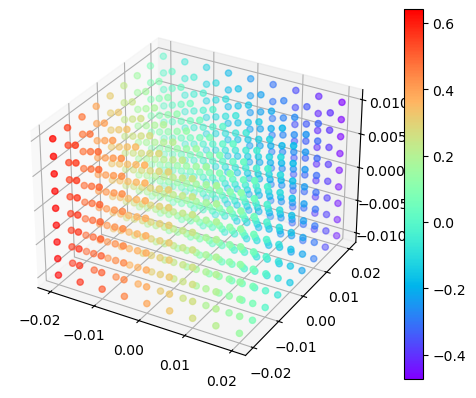

1.1142926


In [43]:
from mpl_toolkits.mplot3d import Axes3D
# 生成随机的三维坐标和对应的数值
n = 100  # 点的数量
i = 8
xyz = pre_strain[i]  # 三维坐标
val = pre_e[i] # 数值

# 创建一个三维的绘图工程
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# ax.set_title("3d_image_show")

# 颜色映射
cmap = plt.cm.rainbow

# 绘制散点图
sc = ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], c=val, cmap=cmap)

# 添加颜色条
plt.colorbar(sc)
plt.show()

print(np.max(val)-np.min(val))

In [44]:
for i in range(9):
    print(np.max(pre_e[i])-np.min(pre_e[i]))

1.100765
1.10621
1.0721753
1.1483858
1.2550011
1.237824
1.0888546
1.2990446
1.1142926


# 6. Initial Structure to Relaxed Energy/Structure (IS2RE/IS2RS) LMDBs

IS2RE/IS2RS LMDBs utilize the SinglePointLmdb dataset. This dataset expects the data to be contained in a SINGLE LMDB file. In addition to the attributes defined by AtomsToGraph, the following attributes must be added for the IS2RE/IS2RS tasks:

- pos_relaxed: Relaxed adslab positions
- sid: Unique system identifier, arbitrary
- y_init: Initial adslab energy, formerly Data.y
- y_relaxed: Relaxed adslab energy
- tags (optional): 0 - subsurface, 1 - surface, 2 - adsorbate


As a demo, we will use the above generated data to create an IS2R* LMDB file.

In [45]:
# 存储的是有应变的基底，乘以16倍就是等价的基底
strain_slab_int = read_cars(refer_slab_copy, car="POSCAR")
strain_slab_opt = read_cars(refer_slab_copy, car="CONTCAR")
strain_slab_eng = read_cars(refer_slab_copy, car="OSZICAR")

1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '

In [46]:
# 存储的是有应变的吸附构型
# strain_adslab_folder = "/media/zwbai/DATA/dft/shear/strain_adslab_copy/"
strain_adslab_int = read_cars(strain_adslab_copy, car="POSCAR")
strain_adslab_opt = read_cars(strain_adslab_copy, car="CONTCAR")
strain_adslab_eng = read_cars(strain_adslab_copy, car="OSZICAR")
strain_adslab_ine = read_cars(strain_adslab_copy, car=["OSZICAR", 0])
len(strain_adslab_int[0]), len(strain_adslab_int[0][0])

1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '

(27, 22)

In [64]:
ml_bulk_l = get_bulk_set(bulk, strain_matrix)  # bulk上施加应变
ml_bulk_d = array2dict(ml_bulk_l)  # 转字典
ml_slab_l0 = bulk2slab(ml_bulk_l)  # 生成表面
ml_slab_l, ml_slab_d = slab2slabs(ml_slab_l0)  # 拓展

ml_strain_adslab = get_strain_adslab(mol_rotate_d, ml_slab_d, sort_nei_l)
ml_strain_adslab_d = array2dict(ml_strain_adslab) 
len(ml_strain_adslab), len(ml_strain_adslab[0])

top_0_top_1_0
top_0_top_1_120
top_0_top_1_240
top_0_bri_12_0
top_0_bri_12_120
top_0_bri_12_240
top_0_hol_123_0
top_0_hol_123_120
top_0_hol_123_240
top_0_hol_012_0
top_0_hol_012_120
top_0_hol_012_240
hol_012_bri_23_0
hol_012_bri_23_120
hol_012_bri_23_240
hol_123_bri_02_0
hol_123_bri_02_120
hol_123_bri_02_240
hol_012_hol_123_0
hol_012_hol_123_120
hol_012_hol_123_240
bri_02_bri_13_0
bri_02_bri_13_120
bri_02_bri_13_240
bri_02_bri_12_0
bri_02_bri_12_120
bri_02_bri_12_240


(27, 22)

#### Initialize AtomsToGraph feature extractor

In [65]:
E0_O2 = -0.98504822e01  # 02分子的能量
E0_O2

-9.8504822

In [72]:
istore = False
if istore:
    ml_GNN_data_d = get_GNN_data(ml_strain_adslab_d, int_eng=None, ads_opt=strain_adslab_opt[1], opt_eng=strain_adslab_eng[1], slab_eng=strain_slab_eng[1], E0_O2=E0_O2)
    with open(ml_GNN_data_dict, "wb") as file:  # 字典形式保存，该格式方便合并
        pickle.dump(ml_GNN_data_d, file)
else:
    with open(pre_GNN_data_dict, "rb") as file:
        ml_GNN_data_d = pickle.load(file)

/home/zwbai/miniconda3/envs/ocp-models2/lib/python3.9/site-packages/pymatgen/io/ase.py:174: UserWarning: Only FixAtoms is supported by Pymatgen. Other constraints will not be set.
  warnings.warn("Only FixAtoms is supported by Pymatgen. Other constraints will not be set.")


#### Initialize LMDB file

In [74]:
if istore:
    del_file(lmdb_file_ml)
    del_file(f"{lmdb_file_ml}-lock")

    db_new = lmdb.open(
        lmdb_file_ml,
        map_size=1024 * 1024 * 1024 * 2,
        subdir=False,
        meminit=False,
        map_async=True,
    )

 /media/zwbai/DATA/dft/all_copy/output/CuO2_strain_ml.lmdb does not exist
 /media/zwbai/DATA/dft/all_copy/output/CuO2_strain_ml.lmdb-lock does not exist


In [75]:
if istore:
    idx = 0  # 数据库方式保存，可以执行机器学习
    for key, value in ml_GNN_data_d.items():
        for value0 in value:
            value0.sid = idx
            # Write to LMDB
            txn = db_new.begin(write=True)
            txn.put(
                f"{idx}".encode("ascii"),
                pickle.dumps(value0, protocol=-1),
            )
            txn.commit()
            db_new.sync()
            print(idx)
            idx += 1
    db_new.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
istore = True  # 是否重新保存

In [76]:
print("lmdb all file path:", lmdb_file_ml)
all_dataset = LmdbDataset({"src": lmdb_file_ml})

all_energies = [data.y_relaxed for data in all_dataset]
mean = np.mean(all_energies)
stdev = np.std(all_energies)
mean, stdev, len(all_energies)

lmdb all file path: /media/zwbai/DATA/dft/all_copy/output/CuO2_strain_ml.lmdb


(-0.3575389851851859, 0.7689612803856016, 594)

In [77]:
train_data, test_data = train_test_split(all_dataset, test_size=0.1)

# Replacing atoms of the substrate

# 7. build DOS dataset 

In [78]:
dos_l, dos_d = read_cars(dos_cal, car="DOSCAR")

1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '

In [79]:
atomdos_l, atomdos_d = read_cars(dos_cal, car="POSCAR")

1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020', '1021'])
1st dict_keys(['1000', '1001', '1002', '

In [80]:
lenth = len(dos_l[0])
shape_dos_l0 = dos_l[0][0].shape
dos_data = np.zeros((len(dos_l) * len(dos_l[0]), shape_dos_l0[0], shape_dos_l0[1]))

for i in range(len(dos_l)):
    for j in range(len(dos_l[0])):
        k = i * lenth + j
        dos_data[k] = dos_l[i][j]
dos_data.shape

(594, 1600, 10)

In [81]:
targets = np.array(all_energies)
targets.shape

(594,)

In [82]:
print(dos_data.shape)
with open(dos_data_file, mode="wb") as f:
    pickle.dump(dos_data, f)
    pickle.dump(targets, f)

(594, 1600, 10)


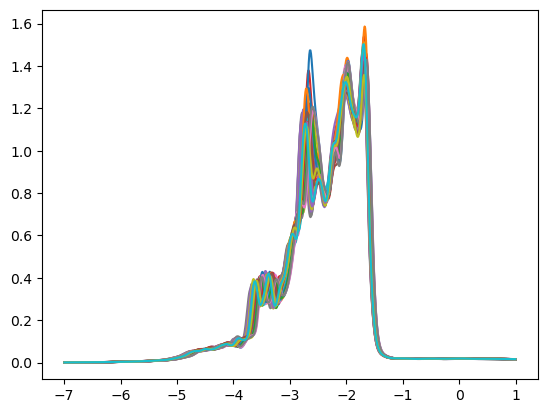

In [83]:
for i in range(0, 50):
    plt.plot(dos_data[j, 100:900, 0], dos_data[i, 100:900, 8])
plt.show()

# 8. Creat Dos Set

## 8.1 Function

In [84]:
def point_position(line_point1, line_point2, point3):
    # 计算
    if line_point1[0] == line_point2[0]:
        # 处理直线垂直于x轴的情况
        return point3[0] != line_point1[0]
    else:
        # 计算直线的斜率
        slope = (line_point2[1] - line_point1[1]) / (line_point2[0] - line_point1[0])

        # 计算第三个点的纵坐标
        y3 = line_point1[1] + slope * (point3[0] - line_point1[0])

        return point3[1] > y3


# 示例数据
line_point1 = (1, 1)
line_point2 = (5, 5)
point3 = (3, 2)

position = "上方" if point_position(line_point1, line_point2, point3) else "下方"
print(f"第三个点在直线的{position}")

第三个点在直线的下方


In [85]:
def atom2graph(atom, dos, threshold=2.8):
    import scipy.sparse as sp

    pos = atom.pos
    cell = atom.cell
    anum = np.array([int(n) for n in atom.atomic_numbers])

    tri = [
        point_position(cell[0][0], cell[0][1], posi[:2])
        and posi[2] > min(sorted(pos[:, 2] - 0.01, reverse=True)[:18])
        for posi in pos
    ]
    coordinates = np.array(pos[tri])
    anum = np.array(anum[tri])

    # 计算原子之间的距离矩阵
    distances = sp_distance.squareform(sp_distance.pdist(coordinates))
    # 创建连接矩阵
    adjacency = np.zeros((len(coordinates), len(coordinates)), dtype=np.float32)

    if type(threshold) is pd.DataFrame:
        for i in range(len(adjacency)):
            for j in range(len(adjacency)):
                cut = threshold[anum[i]][anum[j]]
                adjacency[i, j] = 1 if distances[i, j] < cut else 0  # 标记成键
    else:
        adjacency[distances <= threshold] = 1

    np.fill_diagonal(adjacency, 0)

    # 创建节点特征矩阵（可选)
    dos1 = dos.reshape((1, -1))
    dos0 = np.zeros(dos1.shape)
    dos8 = np.zeros((len(anum), dos1.shape[1]))
    dos8[anum == 8] = dos0
    dos8[anum == 29] = dos1
    node_features = dos8

    # 创建边特征矩阵（可选)
    adj = adjacency.copy()  # 边属性矩阵，来自于链接矩阵
    for i in range(len(anum)):
        if anum[i] == 8:
            for j in range(len(anum)):
                if anum[j] == 8:
                    adj[i, j] = 0  # 不考虑O-O键
    for i in range(len(anum)):
        if anum[i] == 8:
            adj[i, i] = sum(adj[i, :]) + 1  # 计算氧成键
    for i in range(len(anum)):
        if anum[i] != 8:
            for j in range(len(anum)):
                if anum[j] == 8 and adj[i, j] == 1:
                    adj[i, j] = adj[j, j]  # 计算氧成键，1已经分配
    for i in range(len(anum)):
        for j in range(i + 1, len(anum)):
            adj[j][i] = adj[i][j]

    n_edge = int(sum(sum(adjacency)))  # 注意 使用的链接矩阵
    n_edge_features = 4  # 假设每条边有3个属性值
    edges = np.argwhere(adjacency)  # edges包含了所有非零边的坐标
    edge_features = np.zeros((n_edge, n_edge_features))  # 创建一个空的边特征矩阵
    for i, (r, c) in enumerate(edges):
        att = int(max(adjacency[r, c], adj[r, c])) - 1  # 链接矩阵和边属性矩阵的最大值
        if att > 3:
            print(att)
            att = 3
        edge_features[i][att] = 1  # 注意要将属性值从1开始编号转换为从0开始编号

    # 创建标签（可选）
    labels = atom.y_relaxed

    adj_sparse = sp.coo_matrix(adjacency)

    # 创建Graph对象
    graph = Graph(x=node_features, a=adj_sparse, e=edge_features, y=labels)
    return graph

## 8.2 strain model and dos data

In [86]:
with open(dos_data_file, mode="rb") as f:
    surface_dos_data = pickle.load(f)
    targets = pickle.load(f)

In [87]:
surface_dos_data.shape, targets.shape

((594, 1600, 10), (594,))

In [88]:
dosdata = surface_dos_data[:, 100:900, 4:10]
dosdata[:, :, 0] = surface_dos_data[:, 100:900, 0]
dosdata.shape

(594, 800, 6)

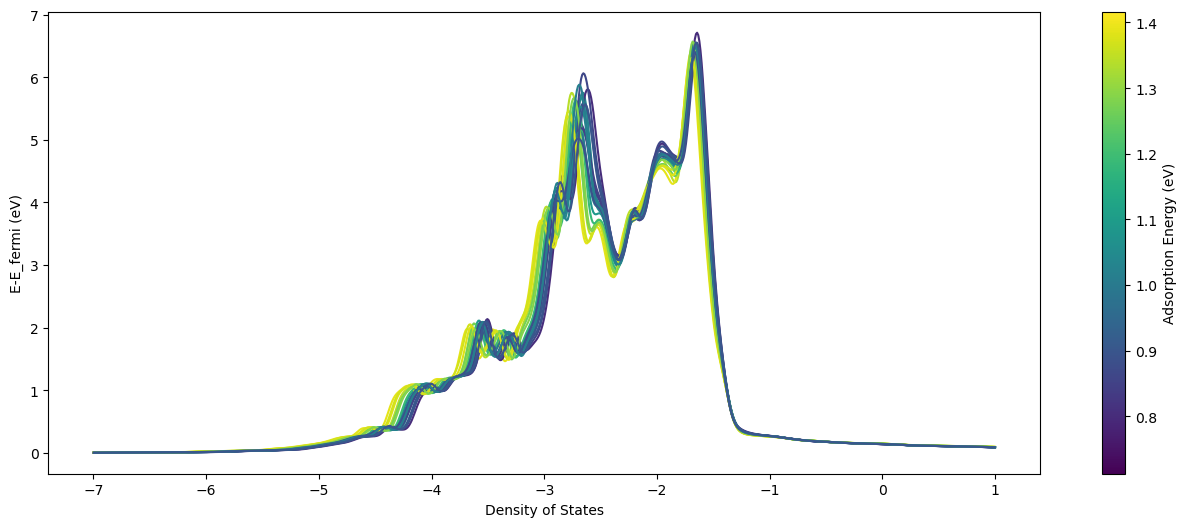

In [89]:
# 创建彩虹图的 colormap
cmap = plt.get_cmap("rainbow")

z = all_energies[:66]
# 创建彩虹图的 colormap
cmap = plt.get_cmap("viridis")

# 设置合适的数值范围
vmin = np.min(z)
vmax = np.max(z)

fig, ax = plt.subplots(figsize=(16, 6))

for i in range(1, 22):
    # color = cmap(z[i])
    color = cmap((z[i] - vmin) / (vmax - vmin))
    # color = cmap(energies[i])  # 根据 z 的值获取对应的颜色
    ax.plot(dosdata[i, :, 0], np.sum(dosdata[i, :, 1:], axis=1), color=color)

# 添加颜色条
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])  # 设置一个空数组，传递给 colorbar
cbar = plt.colorbar(sm, ax=ax)

# 添加标签
ax.set_xlabel("Density of States")
ax.set_ylabel("E-E_fermi (eV)")
cbar.set_label("Adsorption Energy (eV)")

plt.show()

# 8.3 Dataset

In [90]:
row_index = [8, 29]
matrix_zeros = np.zeros([len(row_index), len(row_index)])
columns_index = row_index
table = pd.DataFrame(matrix_zeros, columns=columns_index, index=row_index)
table[:][:] = 2.0
table[29][29] = 2.8
print(table)

     8    29
8   2.0  2.0
29  2.0  2.8


In [91]:
g = atom2graph(all_dataset[66], dosdata[0][:, 1:], threshold=table)
g

Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1)

In [92]:
channel = 5
d = dosdata[0][:, 1:].reshape((1, -1))
d0 = d.reshape(channel, -1).T
d0.shape

(800, 5)

In [93]:
graph_data = []
for i in range(len(all_dataset)):
    g = atom2graph(all_dataset[i], dosdata[i][:, 1:], threshold=table)
    graph_data.append(g)

In [94]:
class MyGraphDataset(Dataset):
    """
    A dataset of density of states of mentals
    """

    def __init__(self, graph_list, **kwargs):
        self.graph_list = graph_list
        super().__init__(**kwargs)

    def download(self):
        if self.path is None:
            print("self.path is None")
        else:
            with open(self.path, "wb") as file:
                pickle.dump(self.graph_list, file)

    def read(self):
        # We must return a list of Graph objects
        output = []
        for i in range(len(self.graph_list)):
            output.append(self.graph_list[i])
        return output

    def __len__(self):
        return len(self.graph_list)

    def __getitem__(self, index):
        return self.graph_list[index]

In [95]:
GraphDataset = MyGraphDataset(graph_data)
GraphDataset[0]

Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1)

In [96]:
GraphDataset.graphs

[Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1),
 Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_lab

In [97]:
# 存储数据到文件
with open(dos_energy_data_file, "wb") as file:
    pickle.dump(GraphDataset, file)

In [98]:
# 从文件中提取数据
with open(dos_energy_data_file, "rb") as file:
    loaded_data = pickle.load(file)

print(loaded_data)  # 输出：[1, 2, 3, 4, 5]
loaded_data[0]

MyGraphDataset(n_graphs=594)


Graph(n_nodes=8, n_node_features=4000, n_edge_features=4, n_labels=1)

In [99]:
exist_folder(data_path, is_creat=True)
for file in pack_data_files:
    shutil.copy(file, data_path)  # copy file for further ML

folder './vasp_cal/' exists


FileNotFoundError: [Errno 2] No such file or directory: '/media/zwbai/DATA/dft/all_copy/output/pre_GNN_data_dict.pkl'

In [ ]:
nostrain_slab_e = read_one_car(Cu_slab_copy, car="OSZICAR") * 4 * 4
nostrain_slab_e

E0 value: -1 F   -.25183315E+02
/media/zwbai/DATA/dft/all/input/Cu_slab_copy/OSZICAR
-25.183315


-402.93304

In [ ]:
nostrain_slabs_e = read_car(nostrain_molecule_copy, car="OSZICAR")

E0 value: -1 F   -.41152881E+03
/media/zwbai/DATA/dft/all/input/nostrain_molecule_copy/1000/OSZICAR
-411.52881
E0 value: -1 F   -.41238936E+03
/media/zwbai/DATA/dft/all/input/nostrain_molecule_copy/1001/OSZICAR
-412.38936
E0 value: -1 F   -.41347738E+03
/media/zwbai/DATA/dft/all/input/nostrain_molecule_copy/1002/OSZICAR
-413.47738
E0 value: -1 F   -.41263940E+03
/media/zwbai/DATA/dft/all/input/nostrain_molecule_copy/1003/OSZICAR
-412.6394
E0 value: -1 F   -.41329765E+03
/media/zwbai/DATA/dft/all/input/nostrain_molecule_copy/1004/OSZICAR
-413.29765
E0 value: -1 F   -.41322994E+03
/media/zwbai/DATA/dft/all/input/nostrain_molecule_copy/1005/OSZICAR
-413.22994
E0 value: -1 F   -.41269243E+03
/media/zwbai/DATA/dft/all/input/nostrain_molecule_copy/1006/OSZICAR
-412.69243
E0 value: -1 F   -.41402914E+03
/media/zwbai/DATA/dft/all/input/nostrain_molecule_copy/1007/OSZICAR
-414.02914
E0 value: -1 F   -.41252577E+03
/media/zwbai/DATA/dft/all/input/nostrain_molecule_copy/1008/OSZICAR
-412.52577
1s

In [ ]:
np.array(nostrain_slabs_e[0]) - nostrain_slab_e - E0_O2

array([ 1.2547,  0.3942, -0.6939,  0.1441, -0.5141, -0.4464,  0.0911, -1.2456,  0.2578])